In [1]:
from torchvision import transforms as tfs
from torch.utils import data
import PIL.ImageOps
from utils import CustomDataGANV4 as cdata
import numpy as np
from utils import utils
import os
import pickle
from utils import Discriminator as netD
from utils import GeneratorV3 as netG
import torch.nn as nn
import torch.optim as optim
import torch
from utils.Plotter import VisdomLinePlotter
import tqdm
from scipy import stats

In [2]:
available_device = 'cuda'

transformations = [
                   #tfs.RandomHorizontalFlip(p=0.7), 
                   #tfs.RandomAffine(0, scale=(0.7, 1.), fillcolor=(255, 255, 255)), 
                   #tfs.RandomRotation((0,360), fill=(255,255, 255)), 
                   tfs.Grayscale(),
                   #tfs.RandomRotation(degrees=(0,45), fill=(255,)),
                   tfs.Resize((128, 128)),
                   tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
                   tfs.ToTensor()
]

transformations_target = [
                   #tfs.RandomHorizontalFlip(p=0.7), 
                   #tfs.RandomAffine(0, scale=(0.7, 1.), fillcolor=(255, 255, 255)), 
                   #tfs.RandomRotation((0,360), fill=(255,255, 255)), 
                   tfs.Grayscale(),
                   #tfs.RandomRotation(degrees=(0,45), fill=(255,)),
                   tfs.Resize((128, 128)),
                   tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
                   tfs.ToTensor()
]

imagenet_data = cdata.CustomDataGAN(
                            '../vasijas/data/perfiles_CATA/png_clasificados/',
                            #'../vasijas/data/perfiles_CATA/png_clasificados_bk_2021',
                            '../fragmentos_vasijas/morfo/',
                            transform=tfs.Compose(transformations),
                            transform_target= tfs.Compose(transformations_target))

imagenet_data.black_image = stats.rv_discrete(name='custm', values=([False, False], [0.5, 0.5]))
imagenet_data.flip_image = stats.rv_discrete(name='custm', values=([False, False], [0.5, 0.5]))

BATCH_SIZE = 4

In [3]:
splits_len = round(len(imagenet_data.samples)*0.2), round(len(imagenet_data.samples)*0.1), round(len(imagenet_data.samples)*0.7)+1
splits_len, np.sum(splits_len), len(imagenet_data.samples) 
#### Random split
splits = utils.random_split(imagenet_data, splits_len)


In [4]:
print('Load indexs files')

file_pi2 = open('datapickle/gan_0.pickle', 'rb') 
splits[0].indices = pickle.load(file_pi2)
print(splits[0].indices.shape)

file_pi2 = open('datapickle/gan_1.pickle', 'rb') 
splits[1].indices = pickle.load(file_pi2)


file_pi2 = open('datapickle/gan_2.pickle', 'rb') 
splits[2].indices = pickle.load(file_pi2)

Load indexs files
torch.Size([207])


In [5]:
train_loader = data.DataLoader(splits[2], batch_size=BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(splits[1], batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(splits[0], batch_size=BATCH_SIZE, shuffle=False)

In [6]:
LR_G = 0.00002 
LR_D = 0.000002

In [7]:
# Model Initialization
model_G = netG.Generator(nc_input=1, nc_output=1).to(available_device)
checkpoint = torch.load("models/generador_v6c_5000.pkl")
#checkpoint = torch.load("models/generador_v6_5000.pkl")
#checkpoint = torch.load("models/generador_v7_5000.pkl")
#checkpoint = torch.load("models/generador_v6_current_2501.pkl")
#checkpoint = torch.load("models/generador_v6_current_2501.pkl")



model_G.load_state_dict(checkpoint)
model_G = model_G.eval()

In [8]:
import matplotlib.pyplot as plt

In [9]:
def imshow_msk(imgs, k):
    plt.figure(figsize=(12,5))
    titles = ['ind - {}: Input 0'.format(k), 'Input 1', 'Result', 'Target', 'Position']
    for i in range(0,4):
        plt.subplot(1, 5, i+1)
        plt.imshow(imgs[i], cmap="gray")
        plt.xticks([])
        plt.yticks([])
        plt.title(titles[i])
   
    
    plt.subplot(1, 5, 5)
    plt.imshow(imgs[2].reshape(128, 128))
    plt.imshow(imgs[0].reshape(128, 128), alpha=0.6)
    #plt.imshow(imgs[1].reshape(128, 128), alpha=0.5)

    plt.xticks([])
    plt.yticks([])
    plt.title(titles[4])
    plt.savefig('result_v6C/row_{}.png'.format(k), bbox_inches='tight',  dpi=300)
    plt.show()

In [10]:
import sys
sys.path.append('../vasijas/')

from models.classifierResnet import _C
C =_C(input_h_w=128)
C = C.to(available_device)#.eval()
checkpoint = torch.load("../vasijas/checkpoint_test_gan.pkl")

In [11]:
import joblib


In [12]:
'''def classifier(predicted):
    #image = image.reshape(-1, 128, 128).unsqueeze(1)
    #image = torch.cat((image, image, image), 1)
    predicted = predicted.reshape(-1, 128, 128).unsqueeze(1)
    predicted = torch.cat((predicted, predicted, predicted), 1)
    _, y_predicted = torch.max(C(predicted), 1)
    return y_predicted'''

def classifier(predicted):
    loaded_model = joblib.load('../vasijas/finalized_model.sav')
    predicted = predicted.reshape(-1,1, 128, 128)
    predicted = torch.cat((predicted, predicted, predicted), 1)
    y_predicted = C.forward_partial(predicted)
    return loaded_model.predict(y_predicted.detach().cpu().tolist())
    
def classifier_partial(predicted):
    predicted = predicted.reshape(-1,1, 128, 128)
    predicted = torch.cat((predicted, predicted, predicted), 1)
    y_predicted = C.forward_partial(predicted)
    return y_predicted

In [13]:
import random

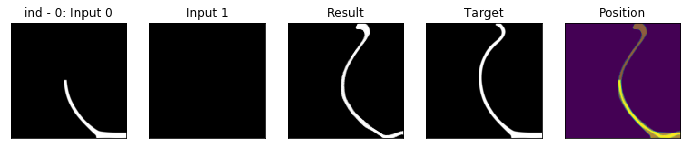

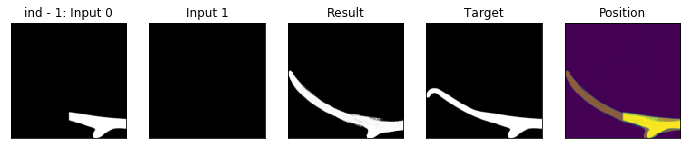

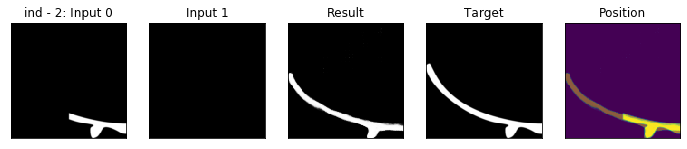

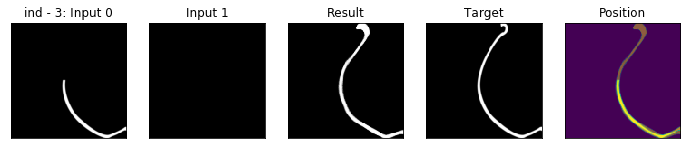

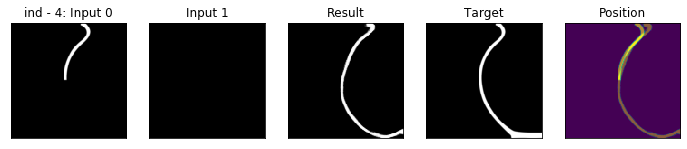

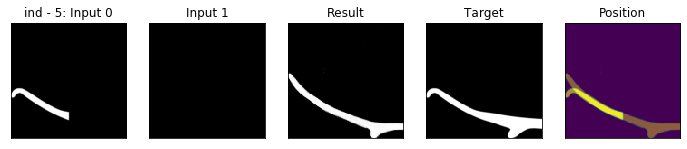

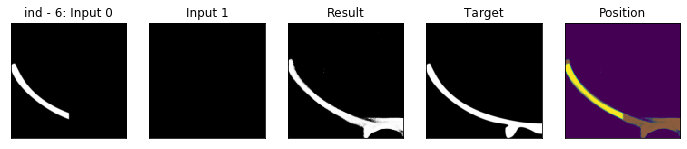

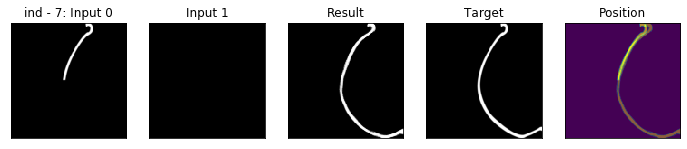

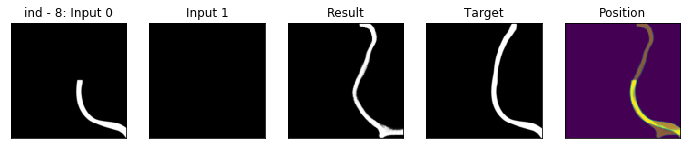

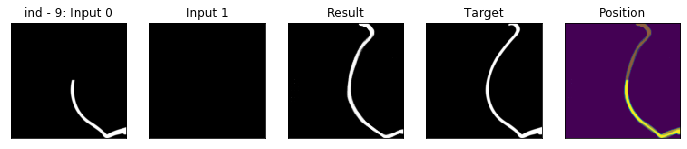

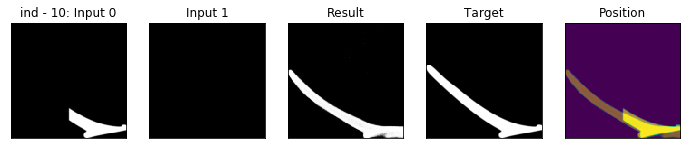

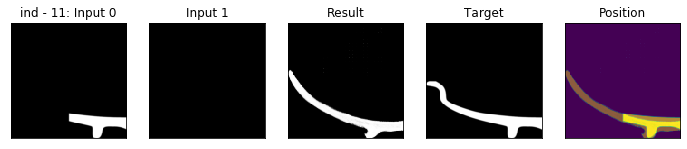

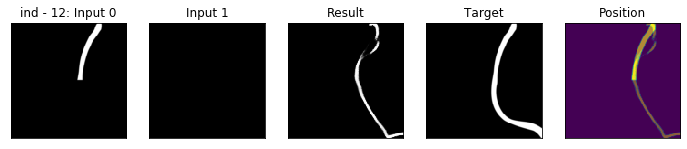

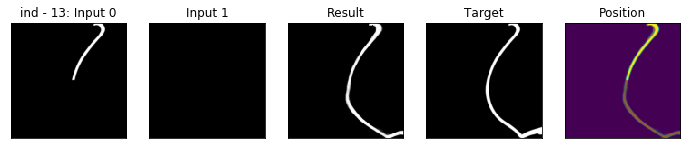

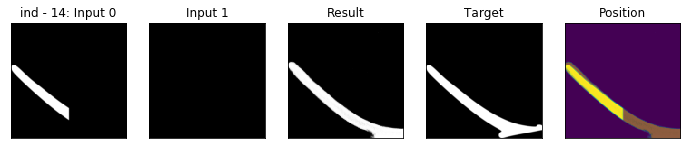

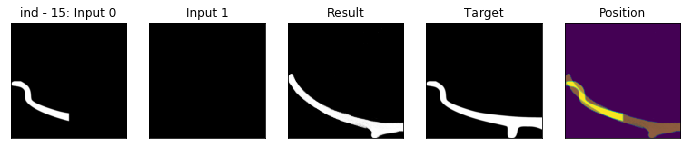

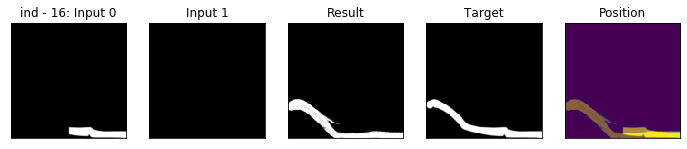

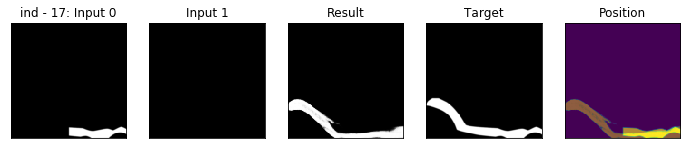

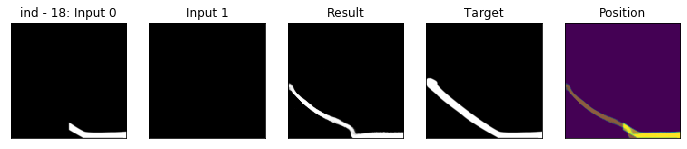

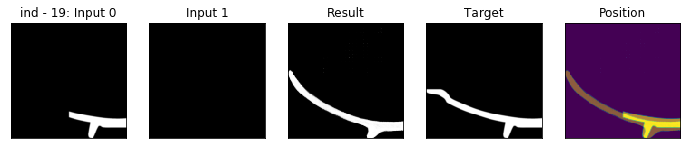

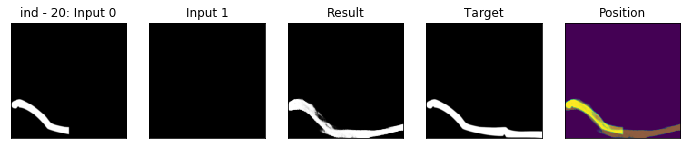

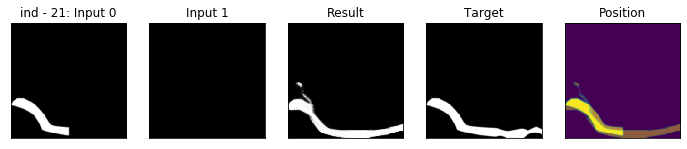

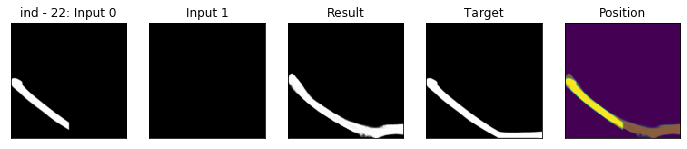

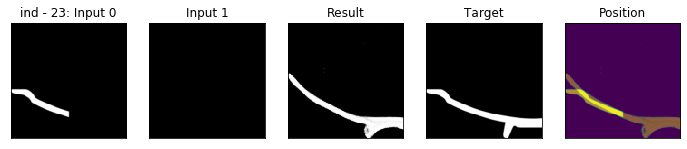

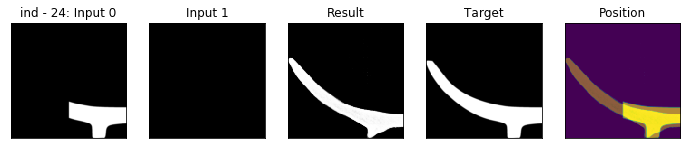

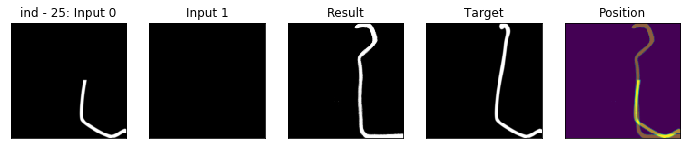

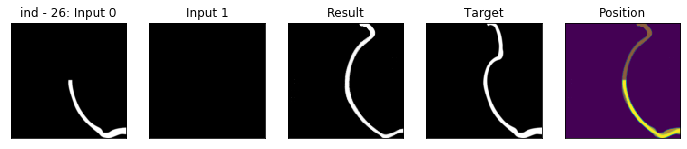

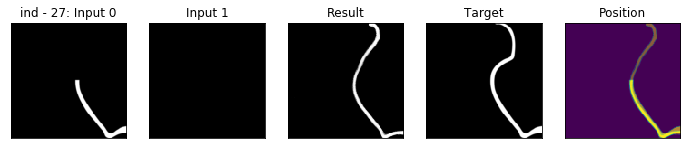

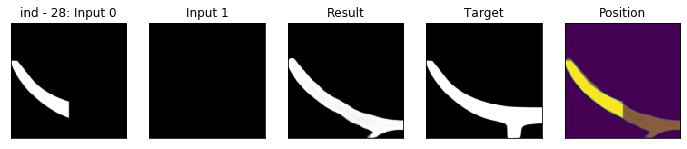

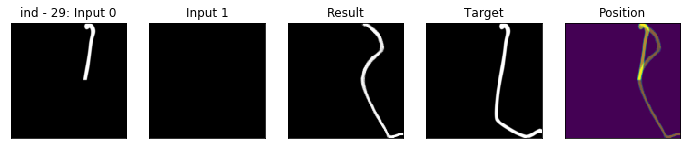

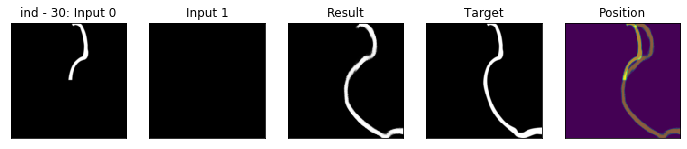

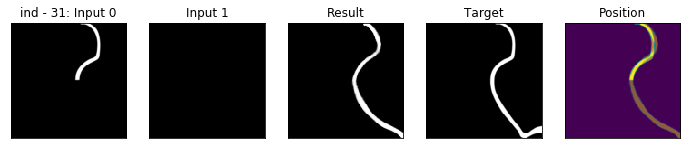

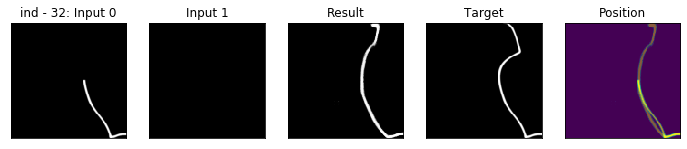

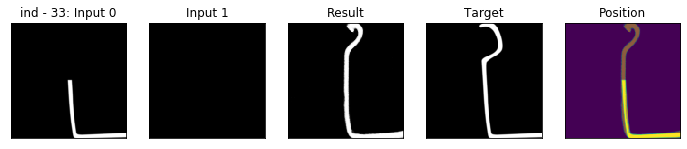

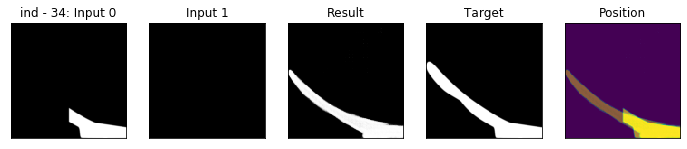

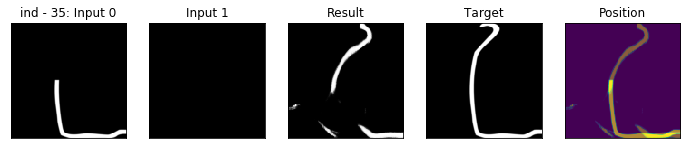

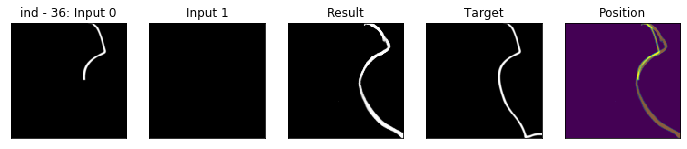

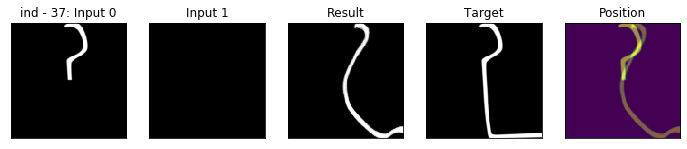

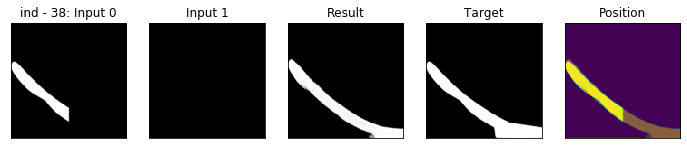

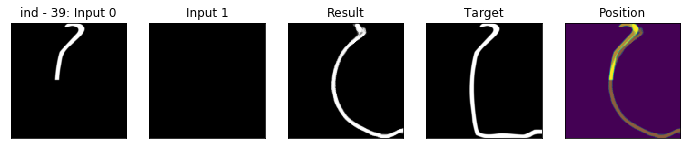

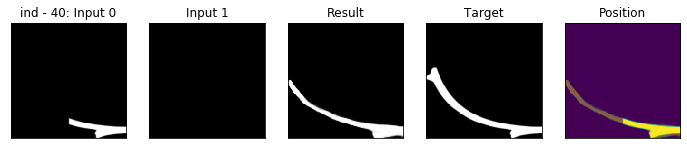

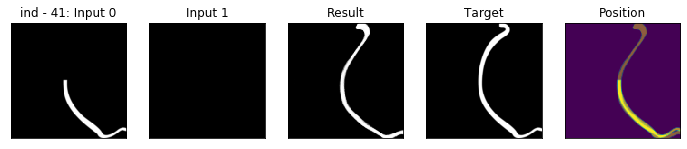

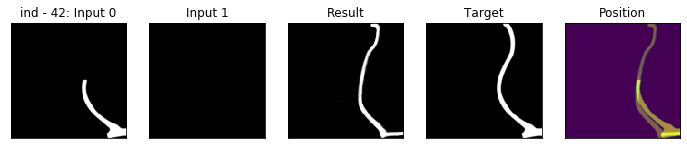

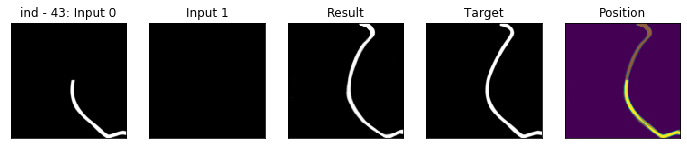

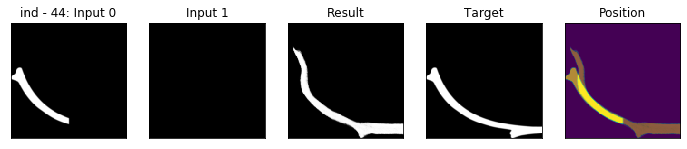

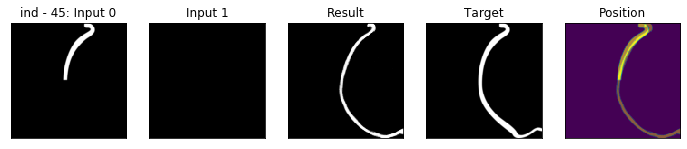

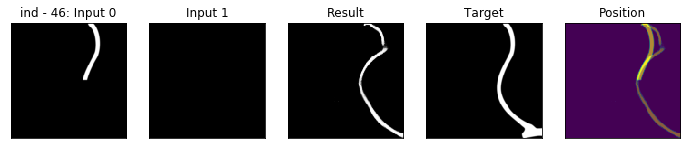

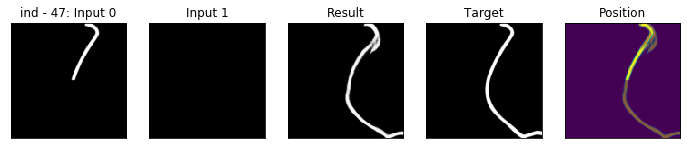

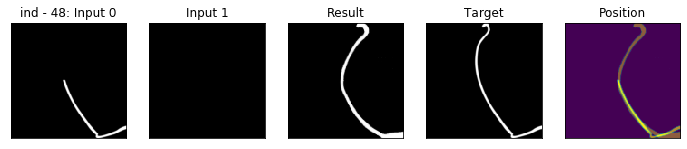

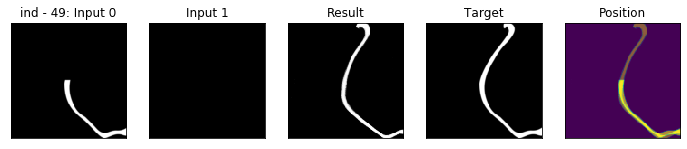

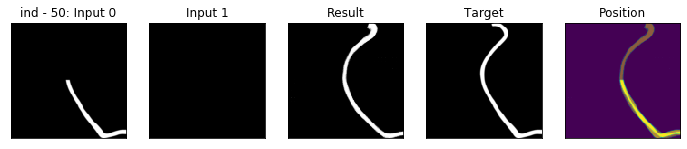

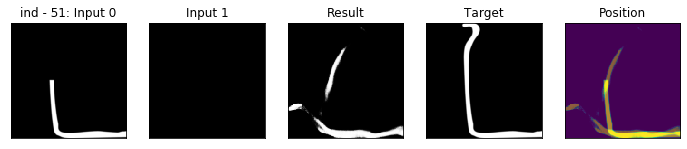

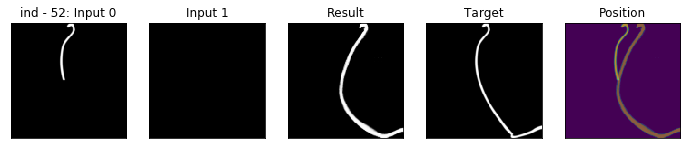

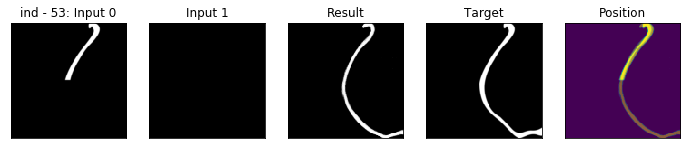

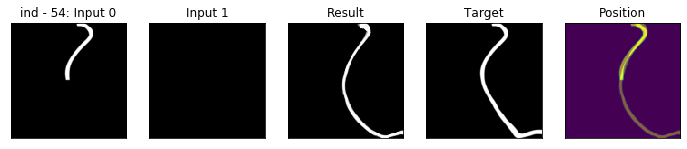

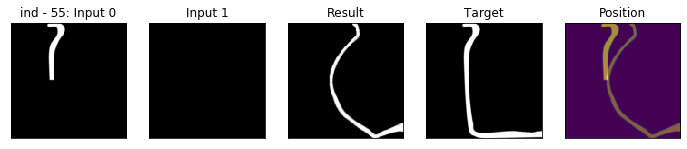

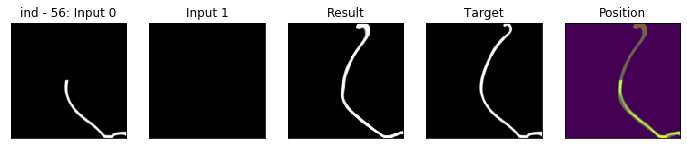

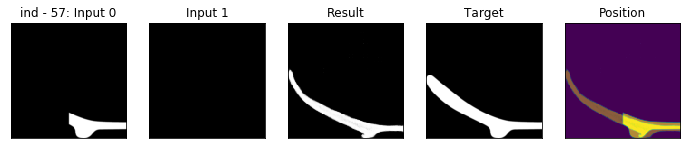

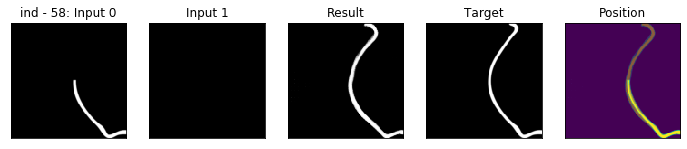

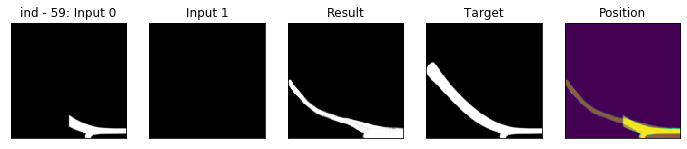

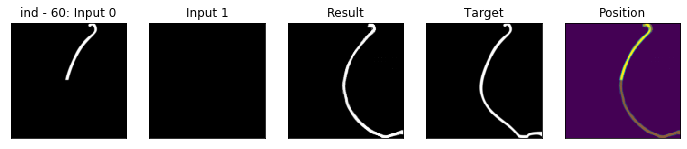

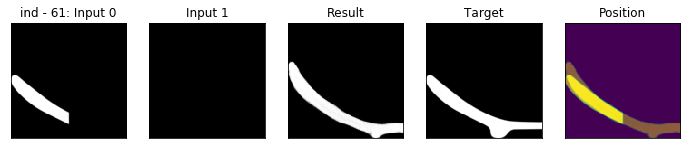

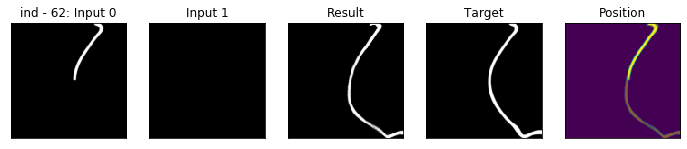

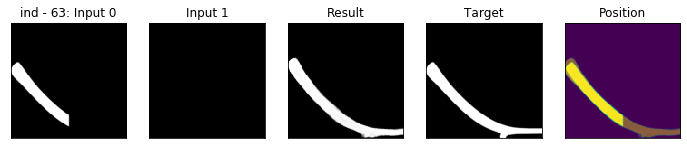

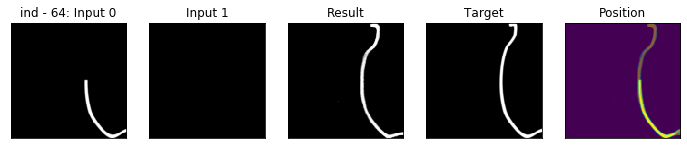

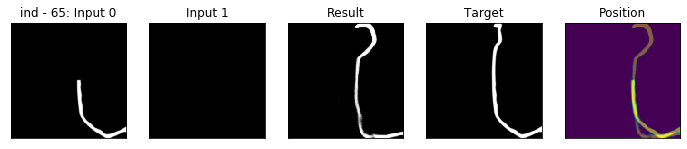

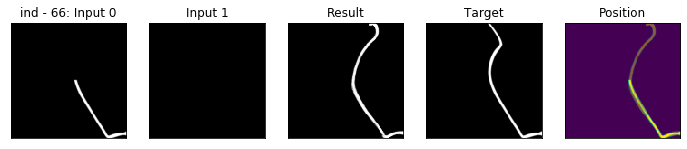

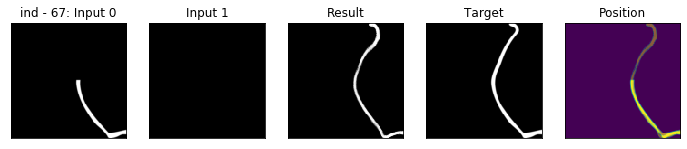

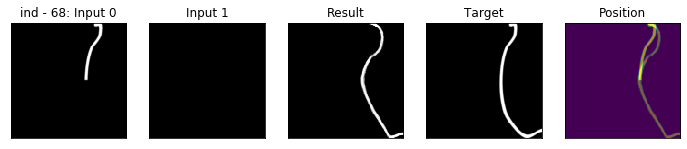

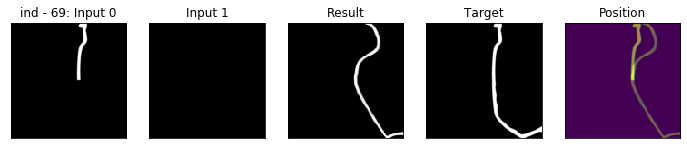

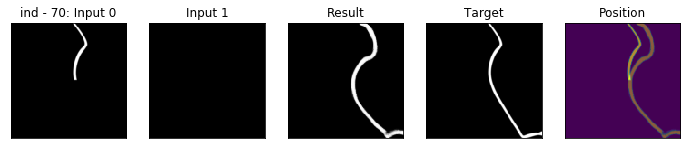

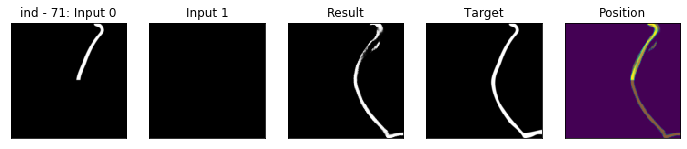

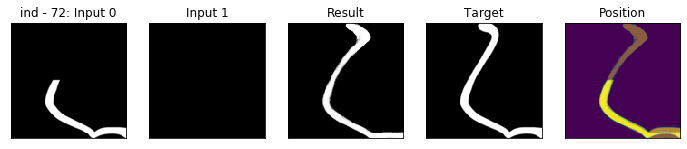

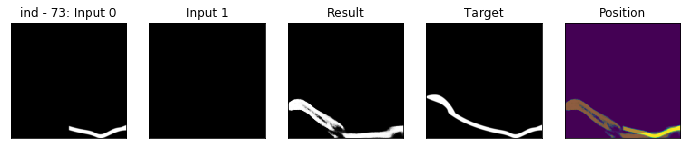

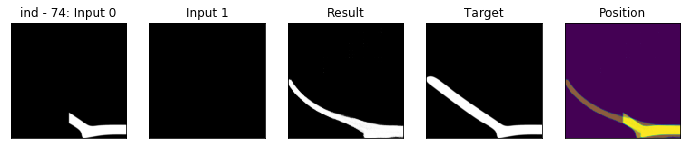

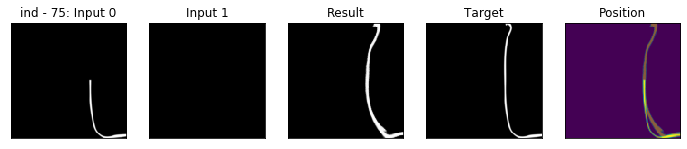

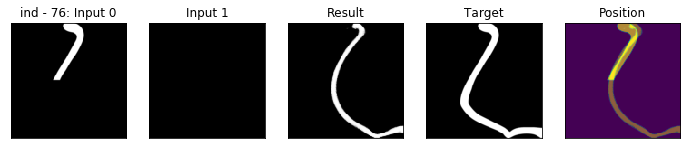

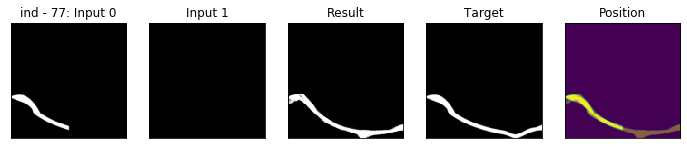

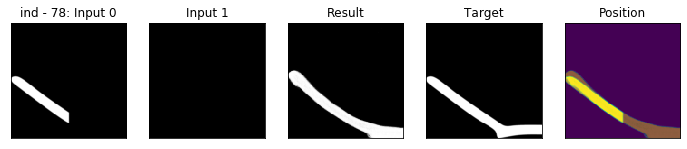

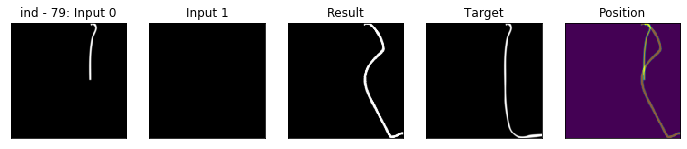

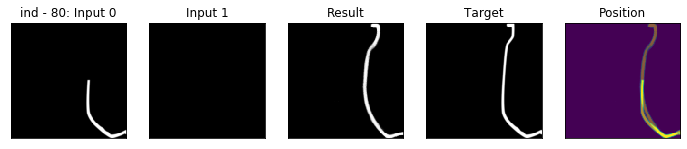

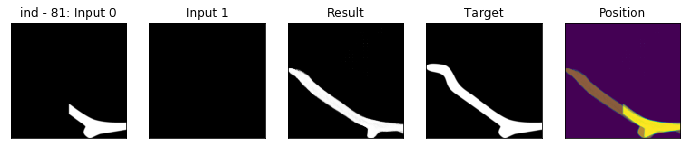

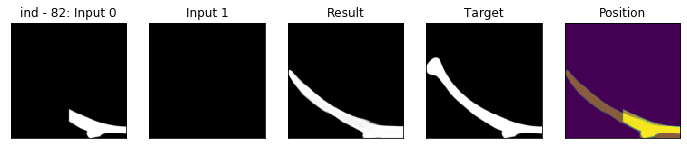

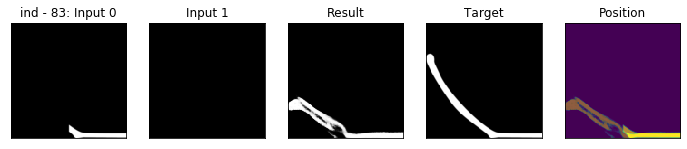

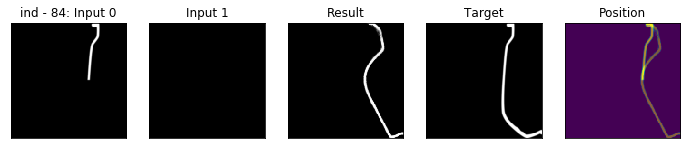

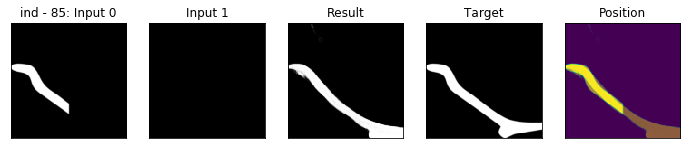

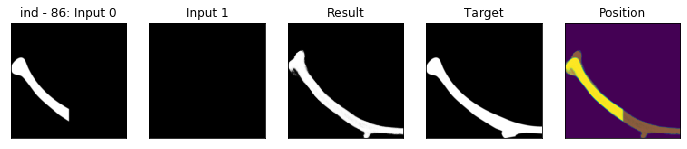

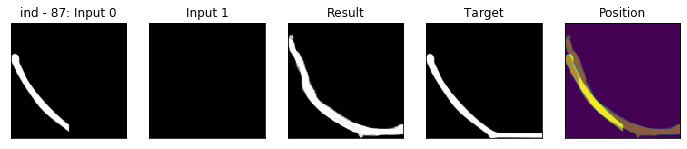

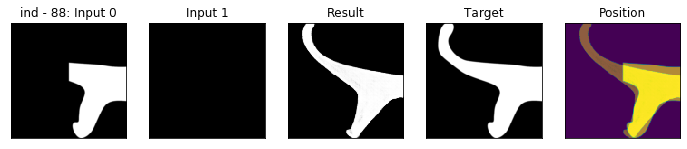

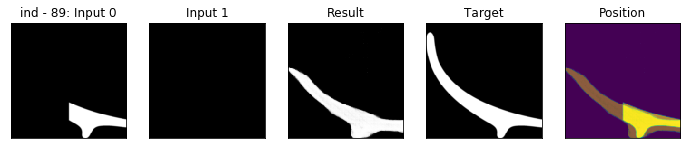

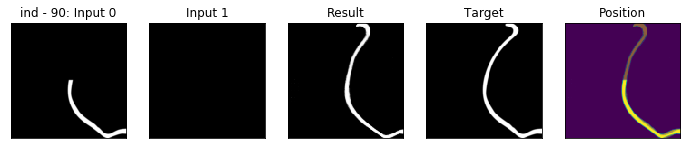

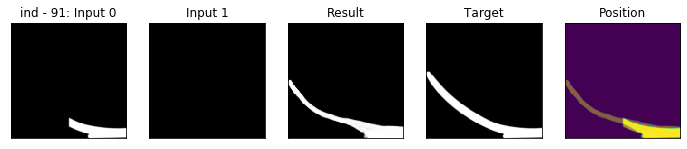

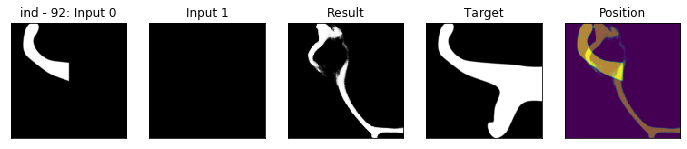

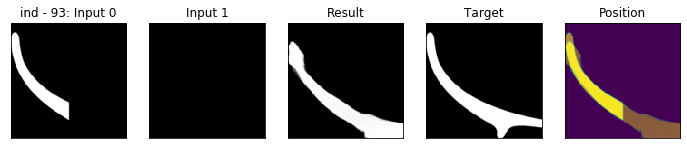

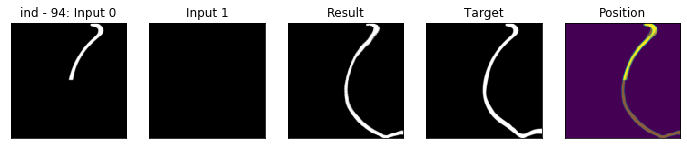

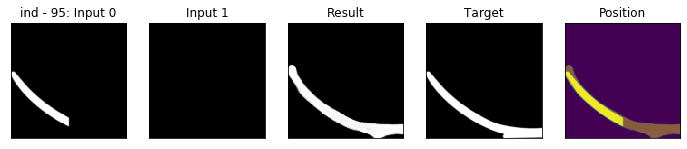

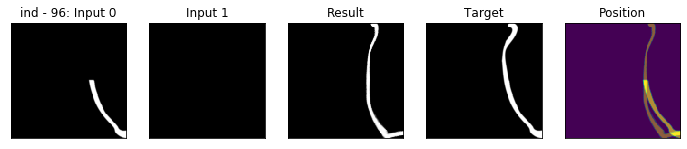

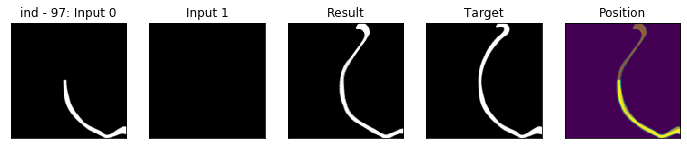

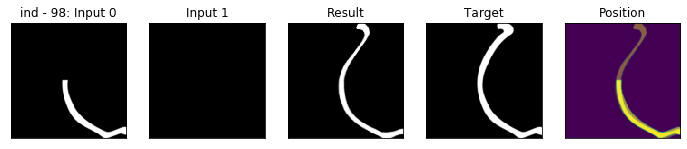

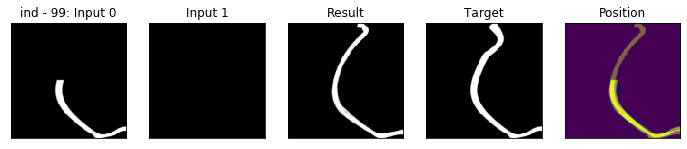

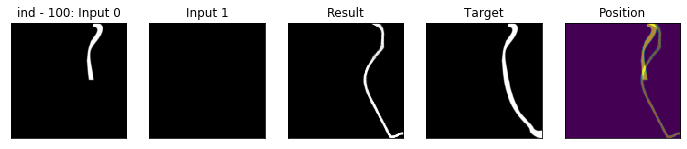

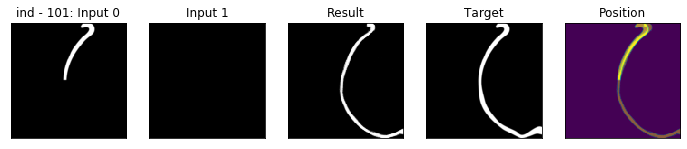

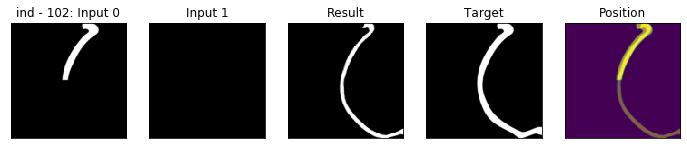

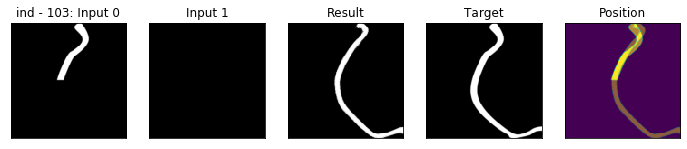

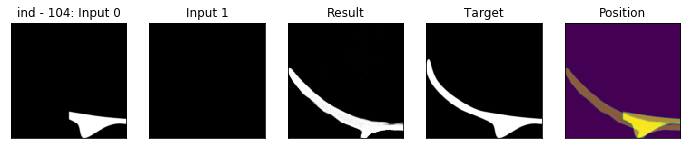

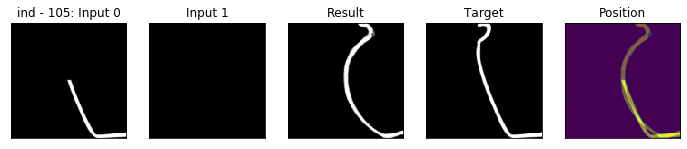

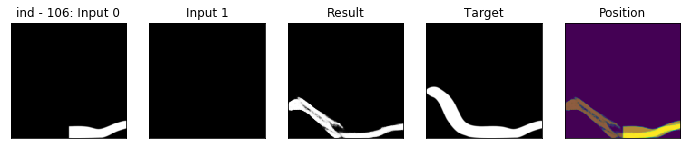

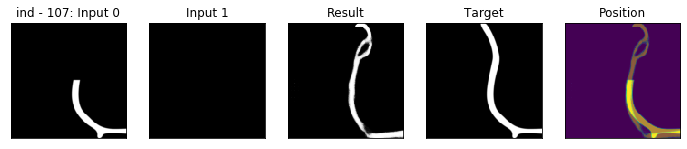

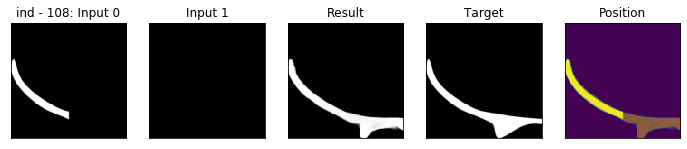

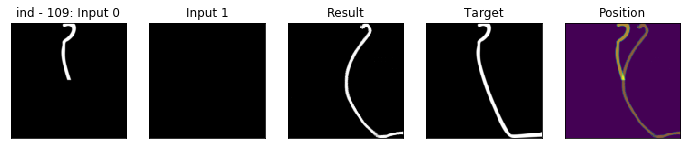

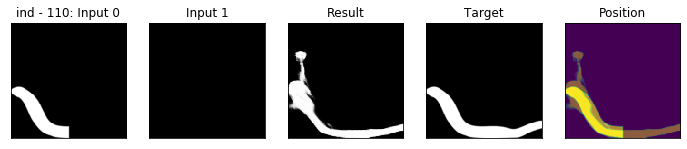

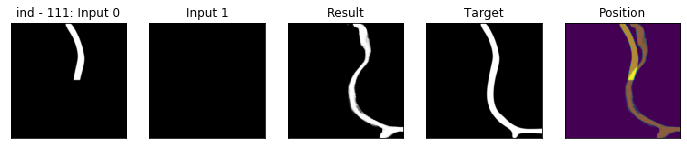

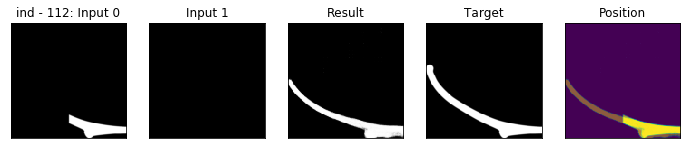

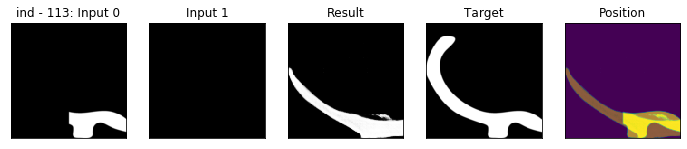

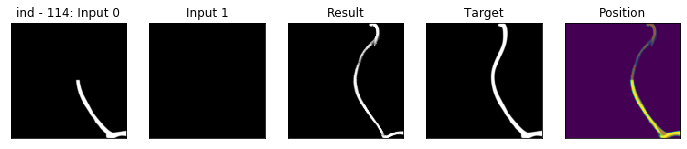

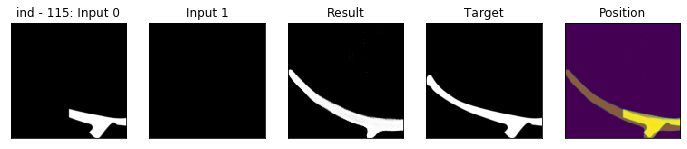

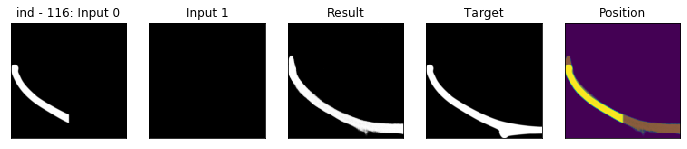

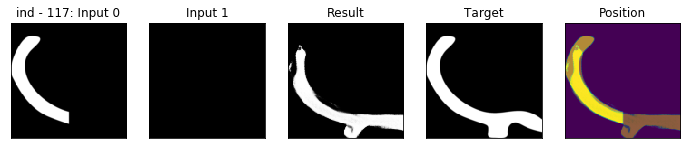

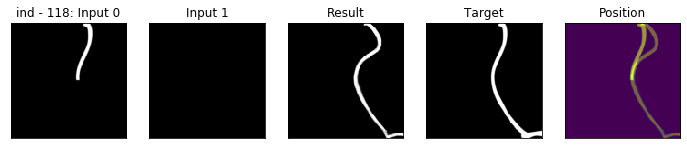

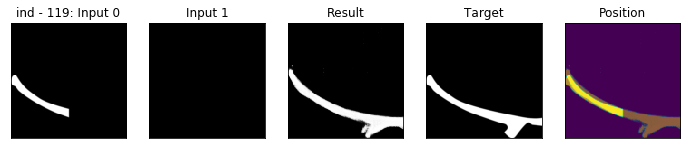

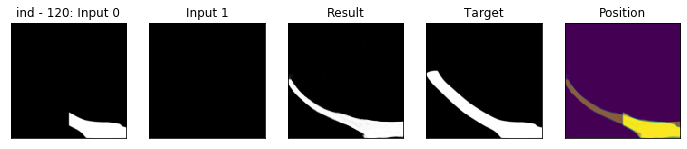

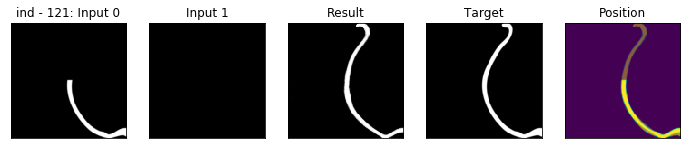

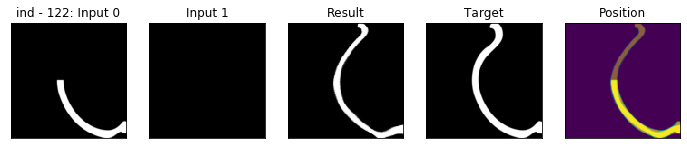

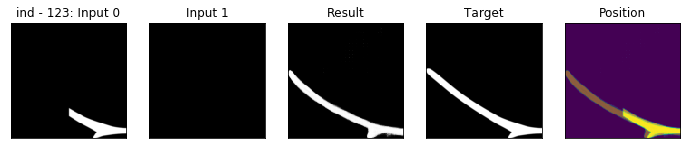

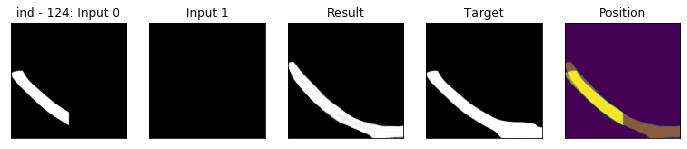

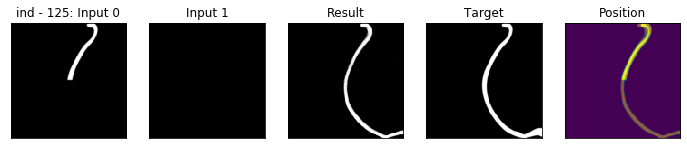

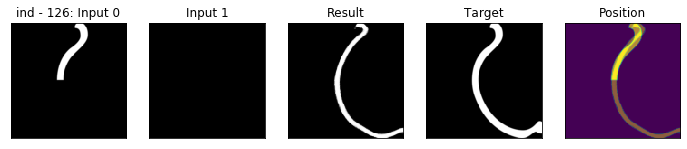

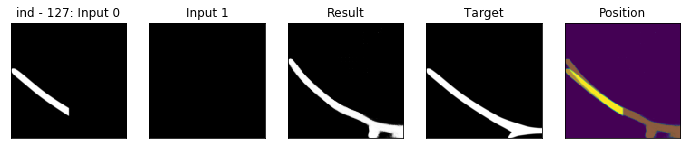

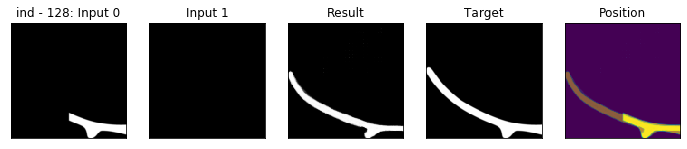

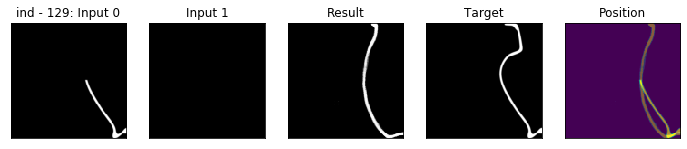

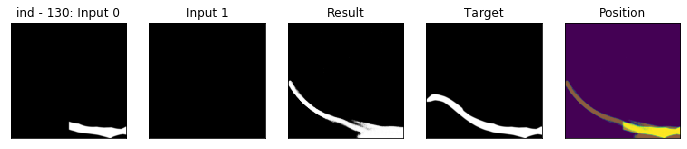

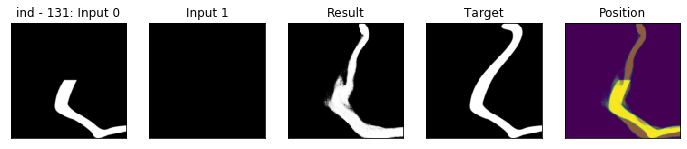

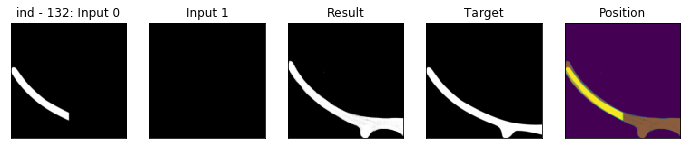

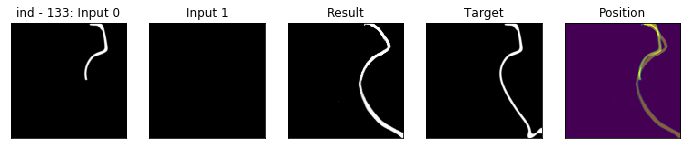

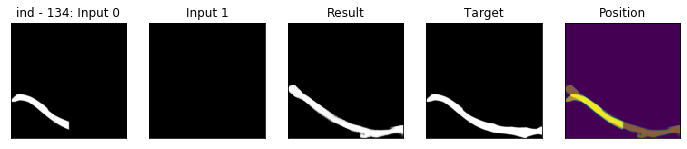

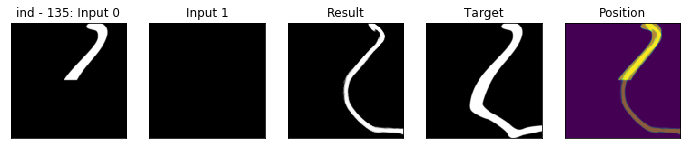

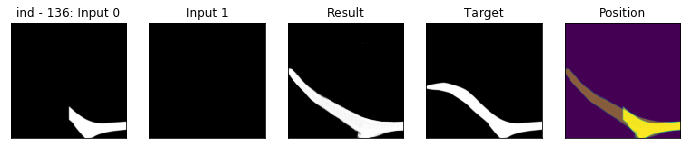

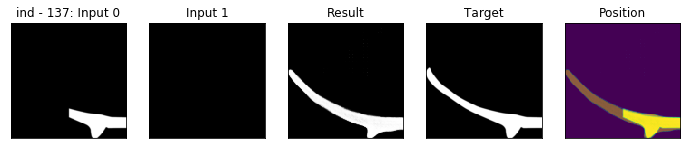

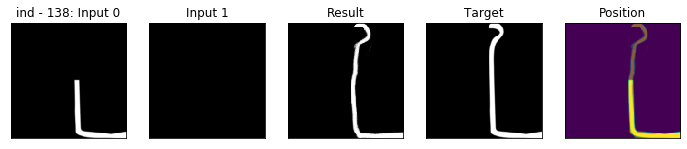

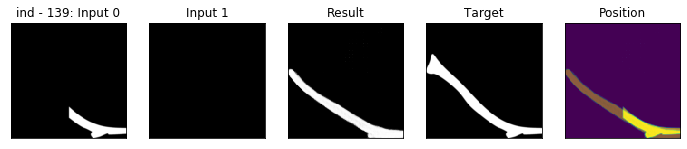

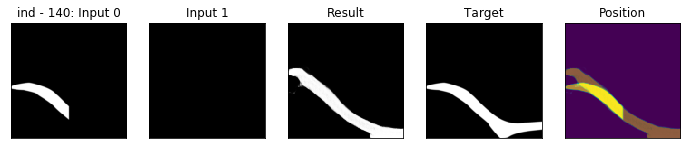

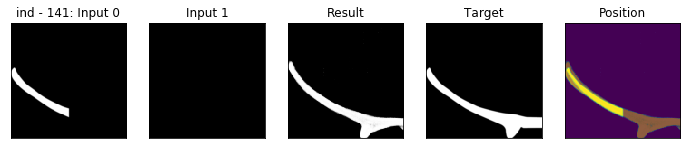

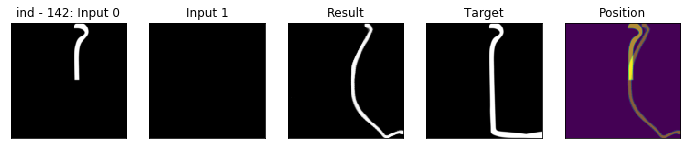

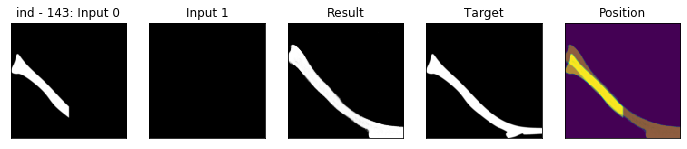

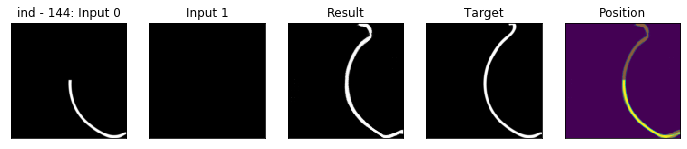

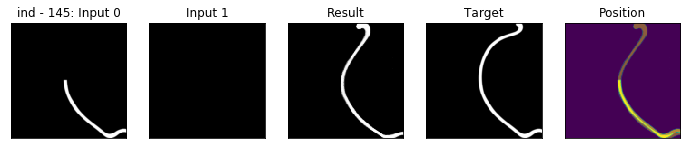

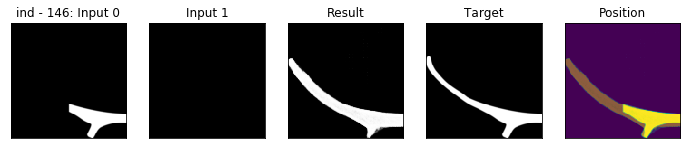

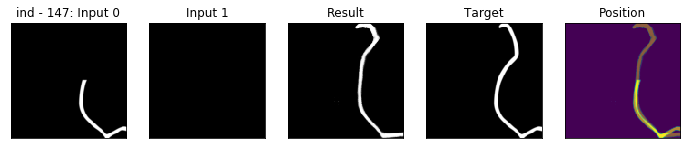

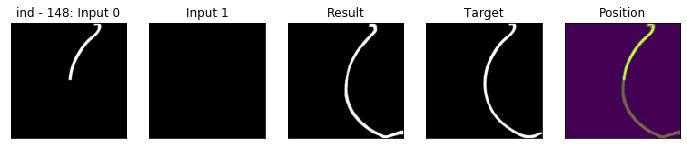

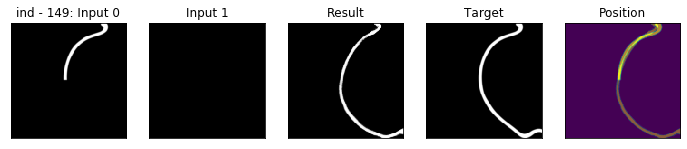

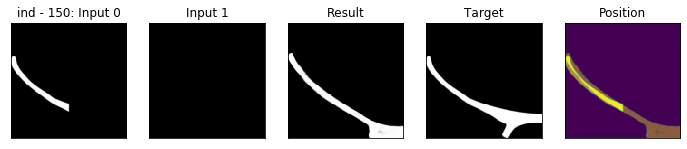

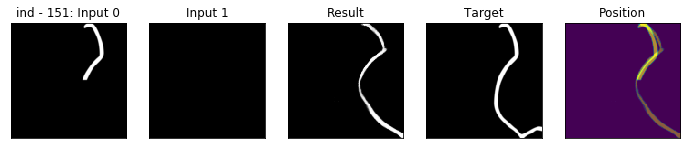

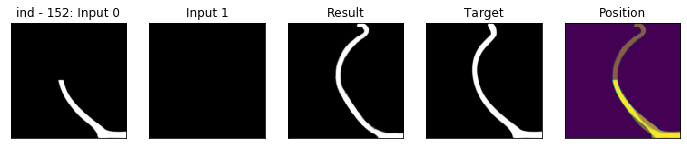

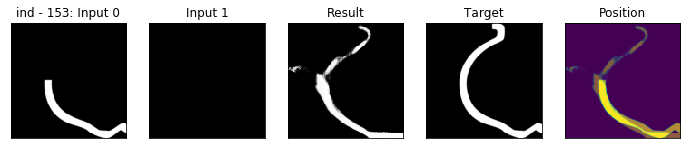

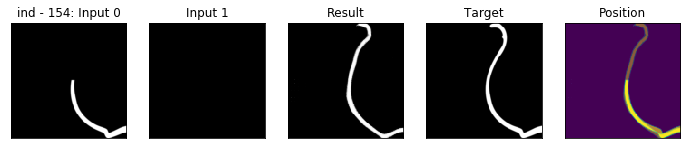

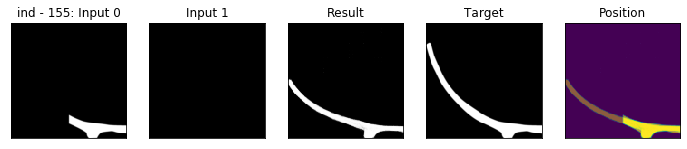

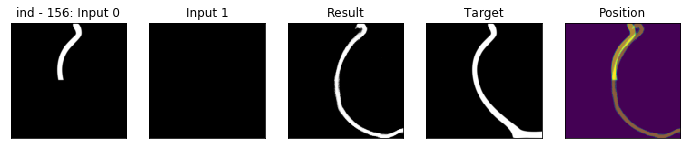

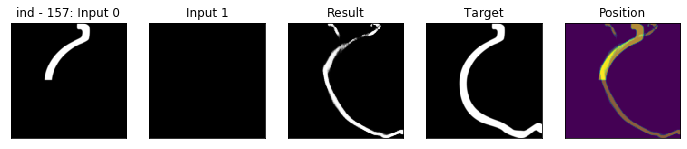

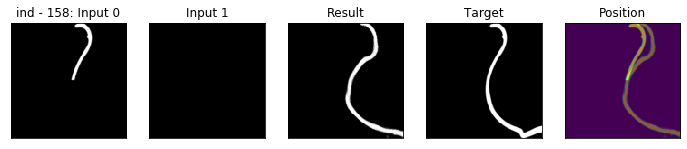

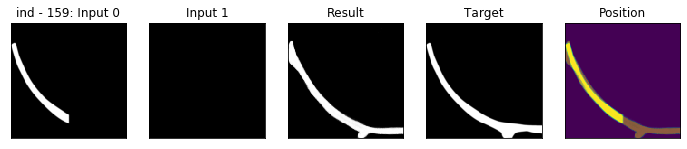

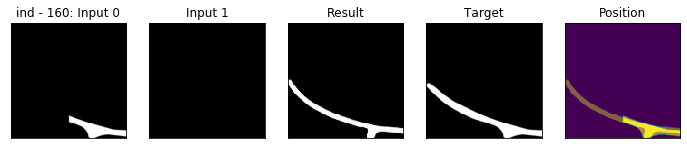

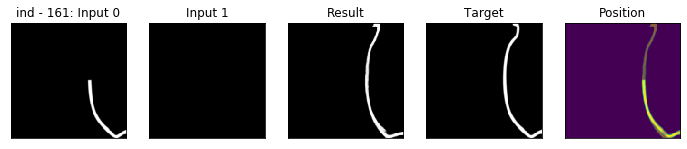

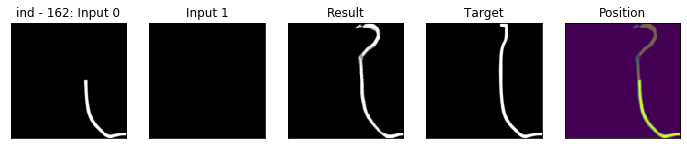

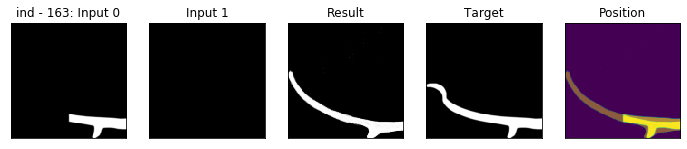

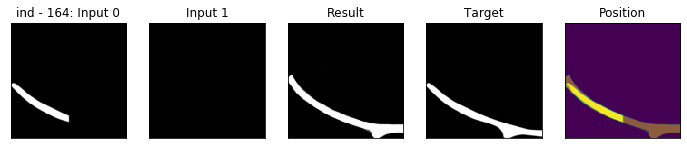

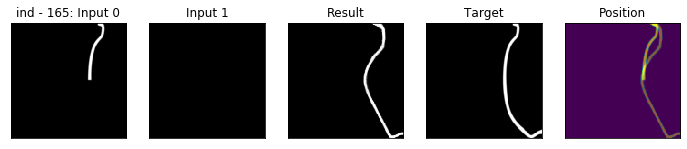

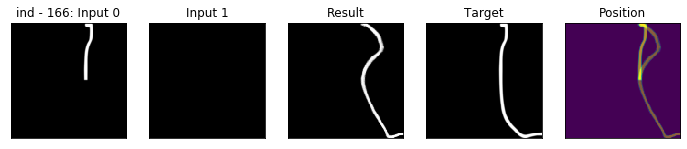

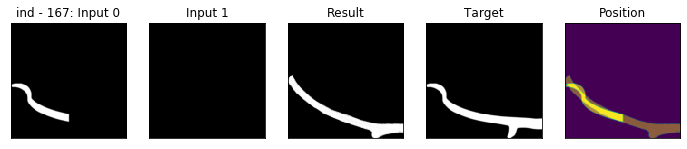

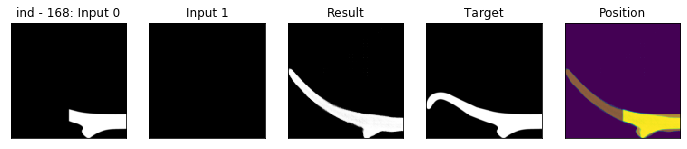

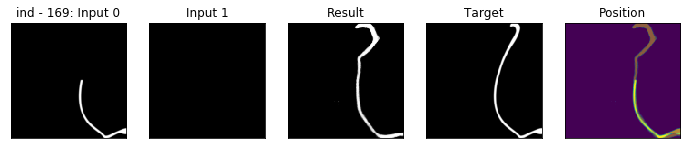

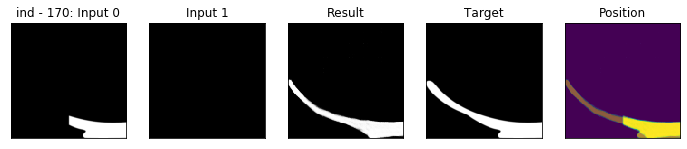

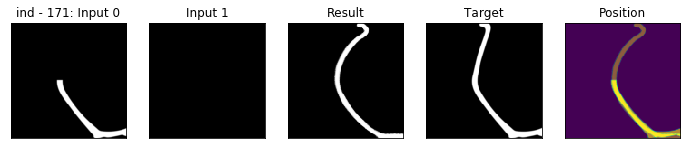

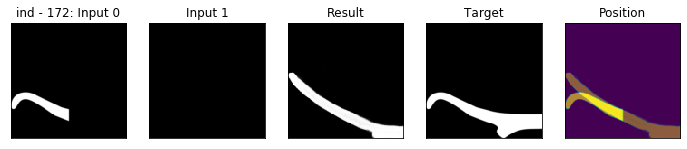

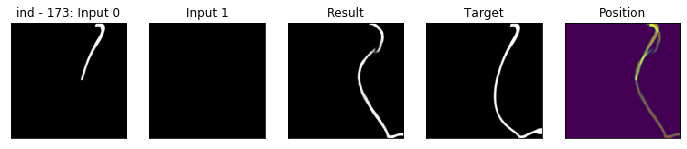

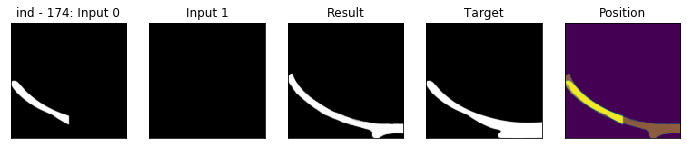

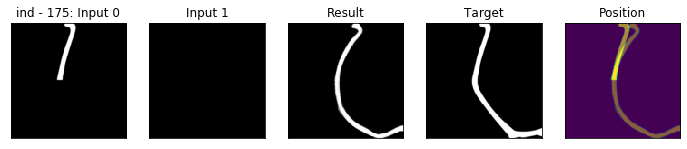

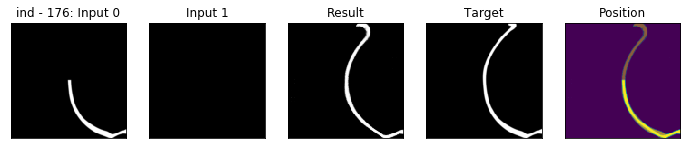

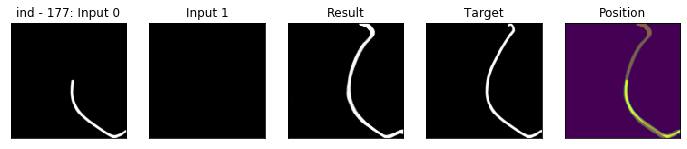

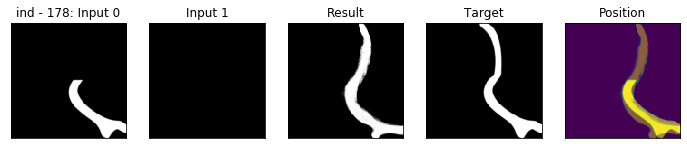

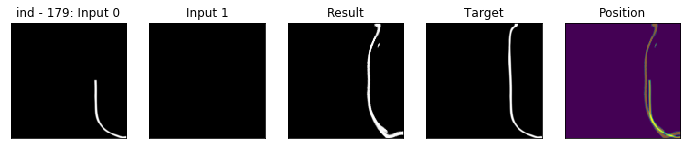

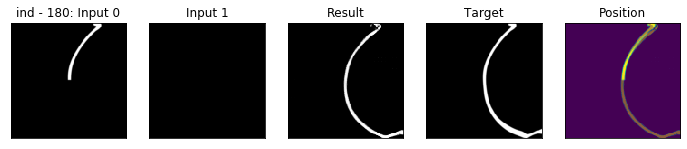

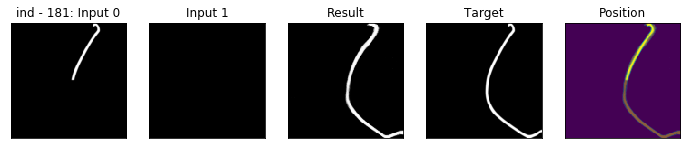

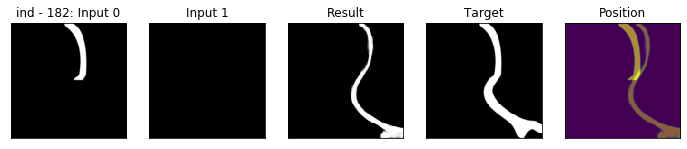

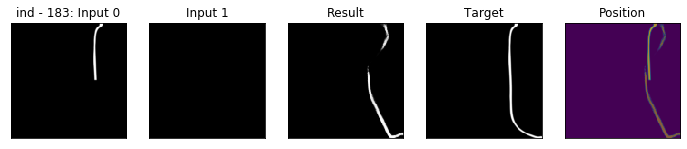

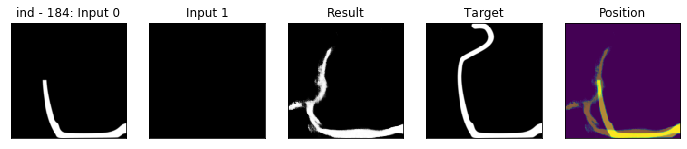

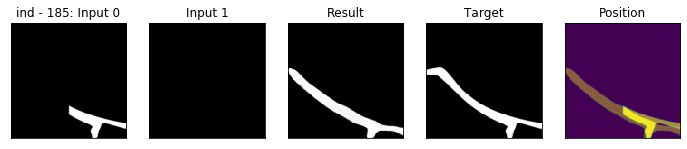

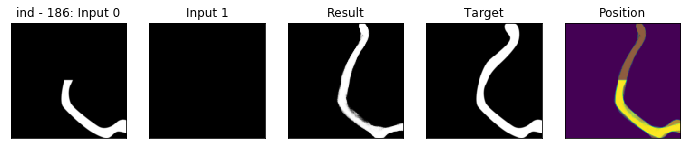

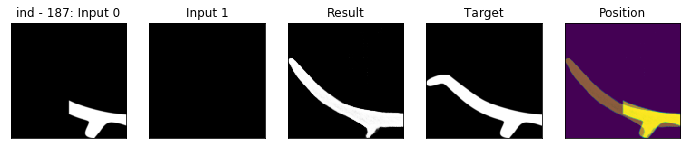

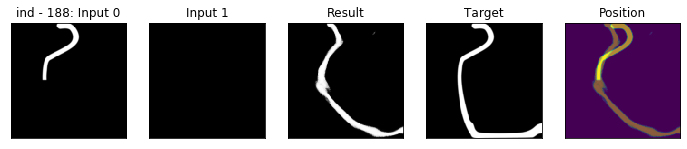

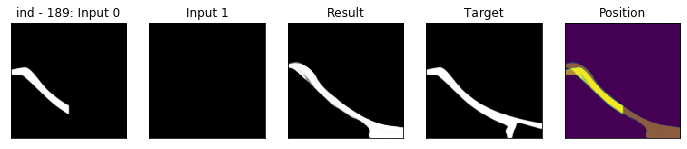

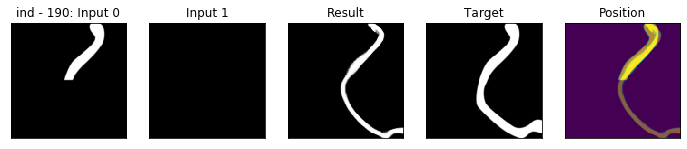

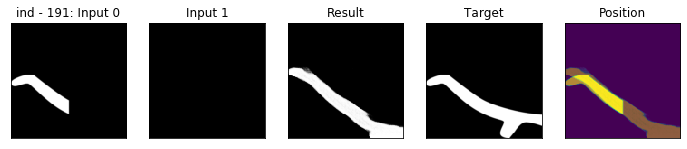

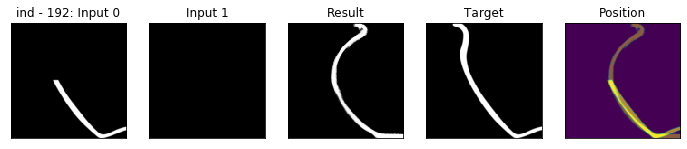

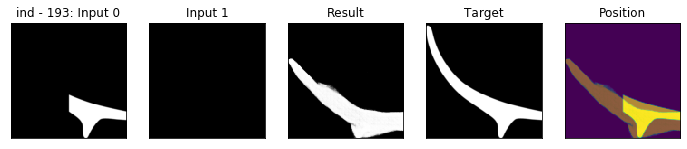

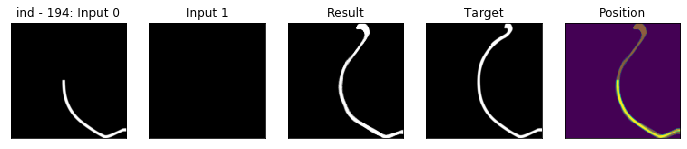

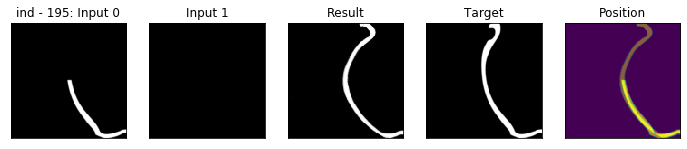

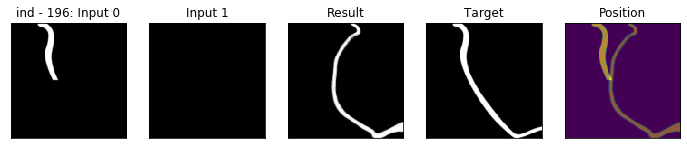

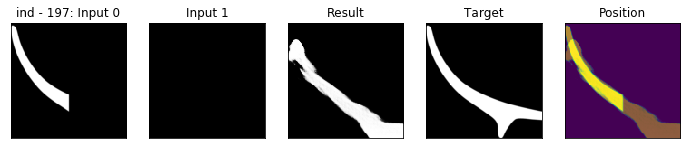

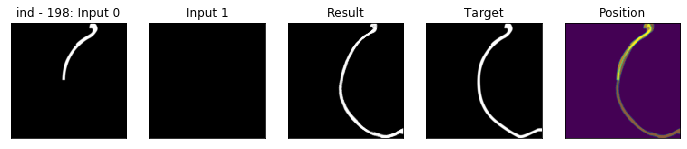

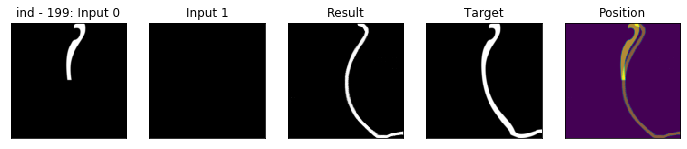

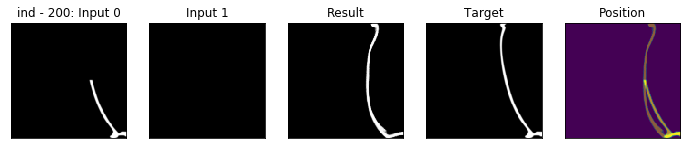

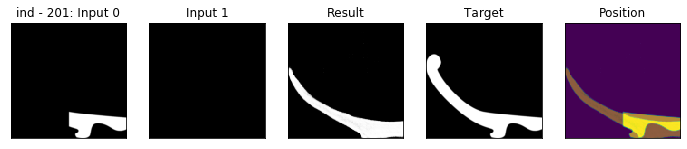

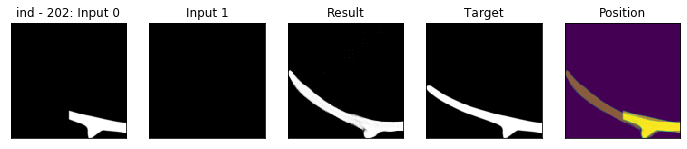

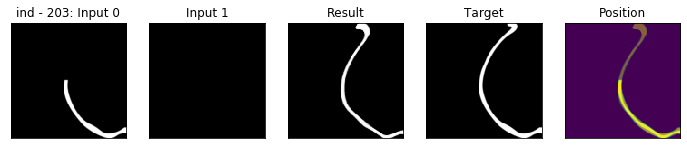

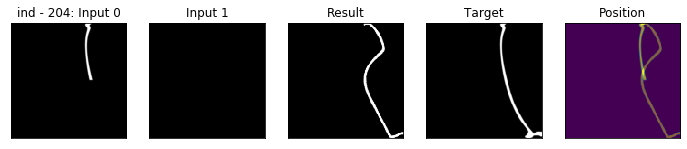

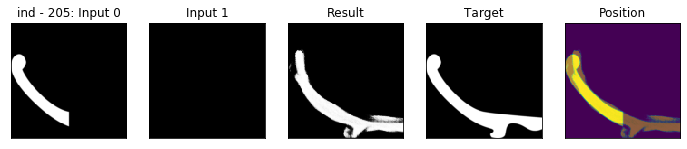

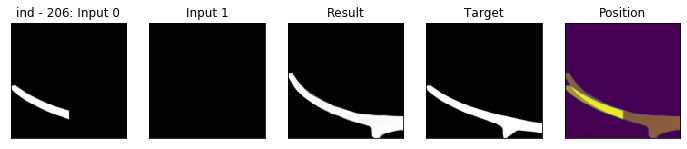

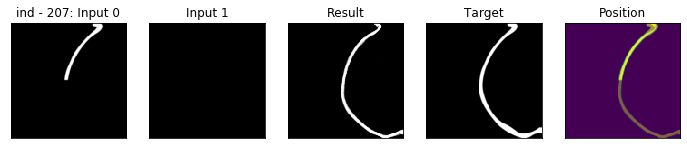

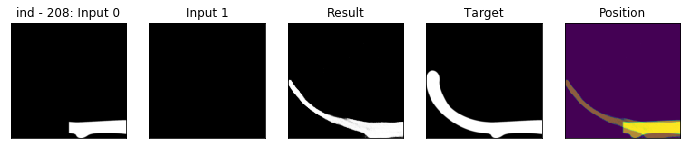

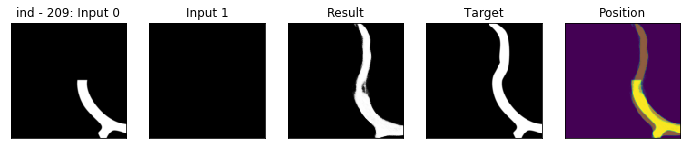

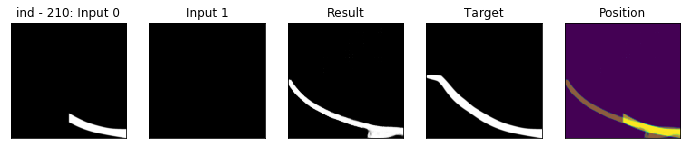

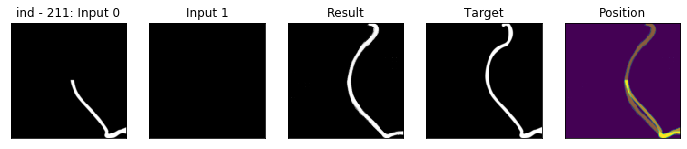

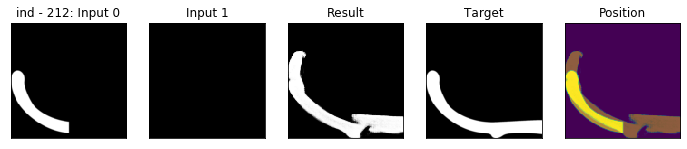

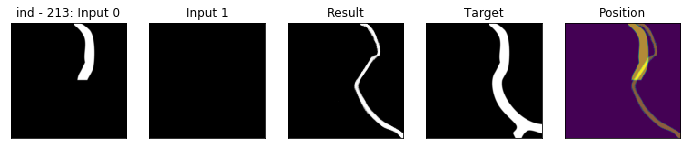

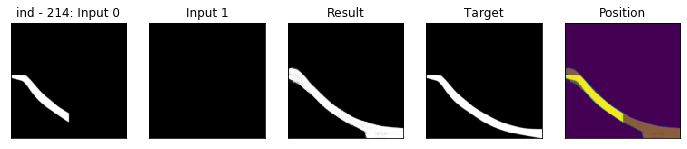

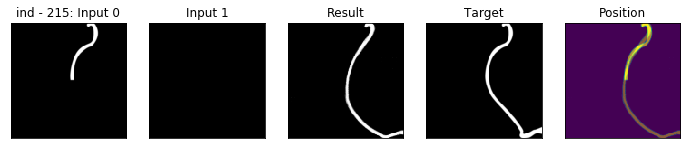

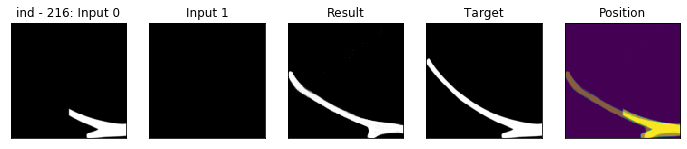

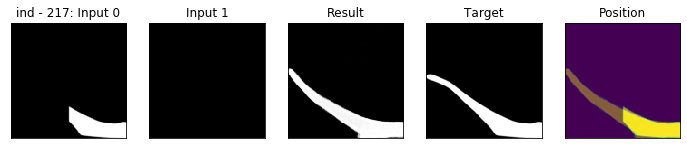

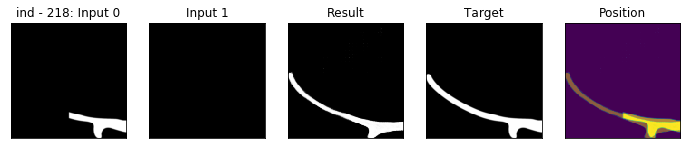

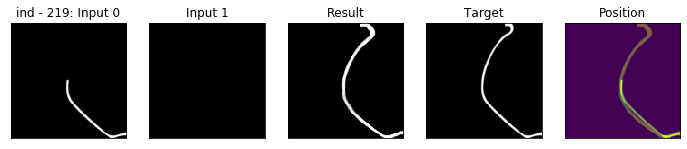

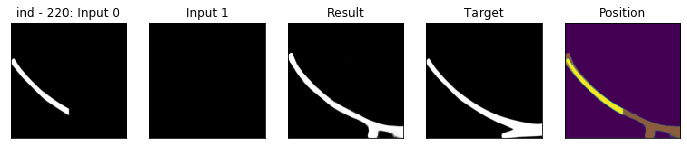

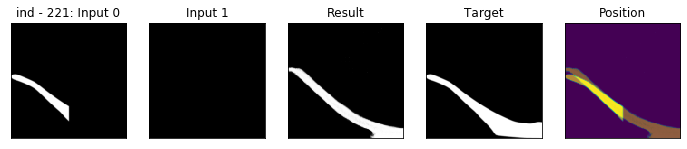

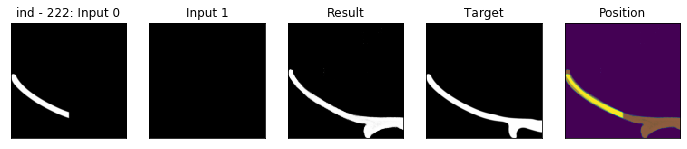

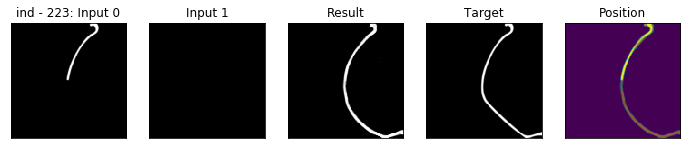

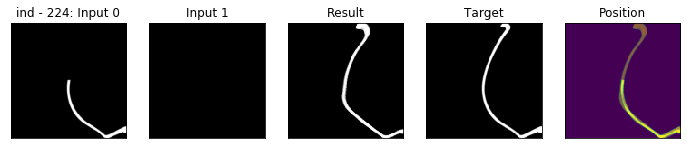

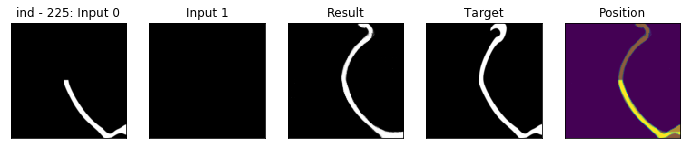

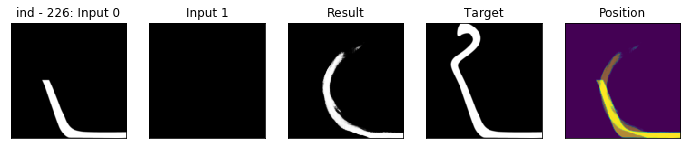

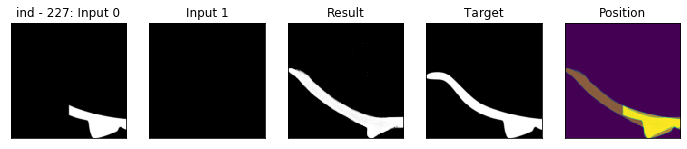

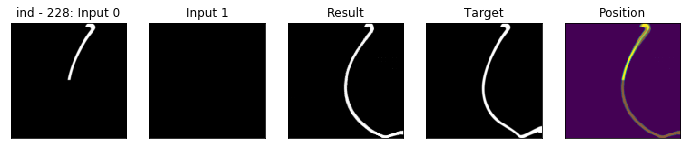

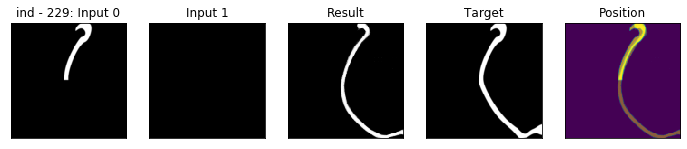

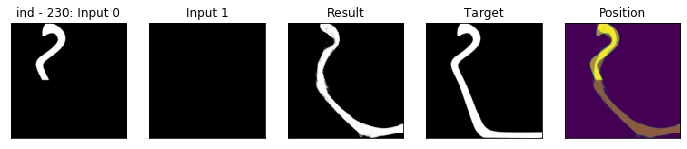

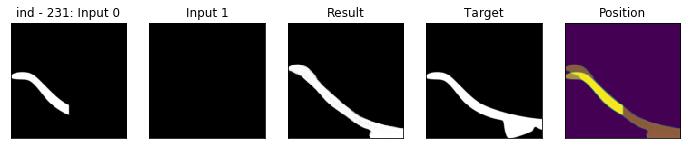

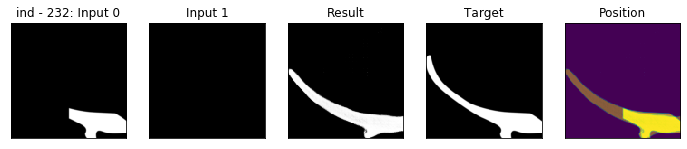

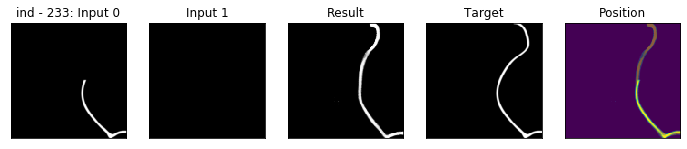

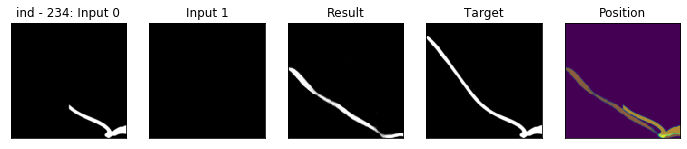

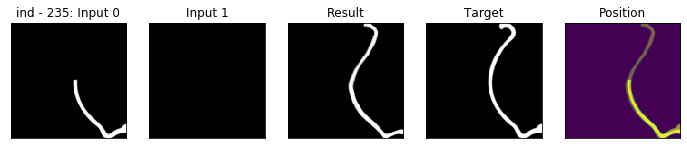

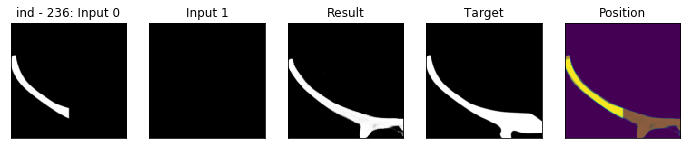

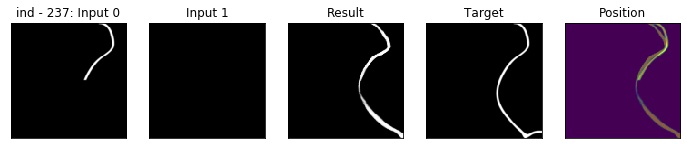

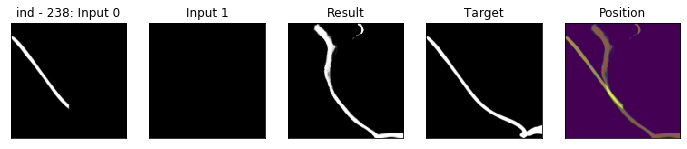

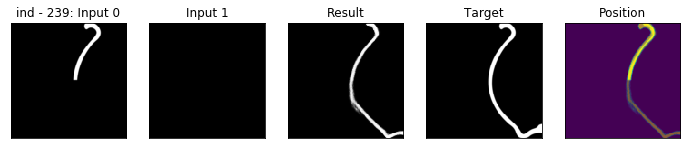

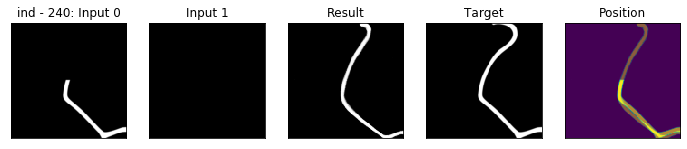

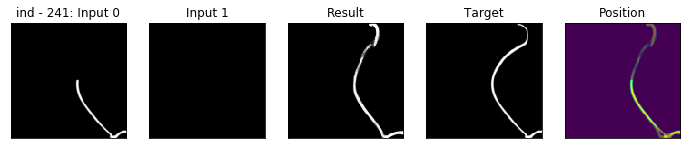

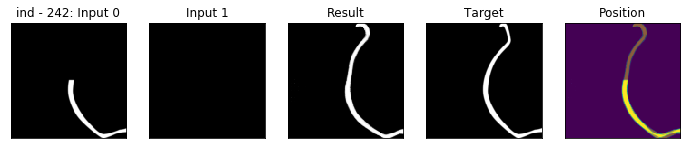

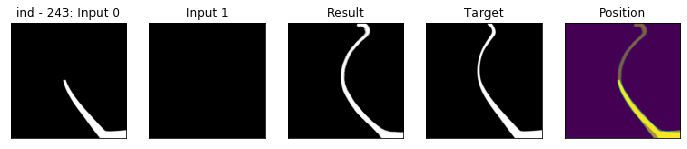

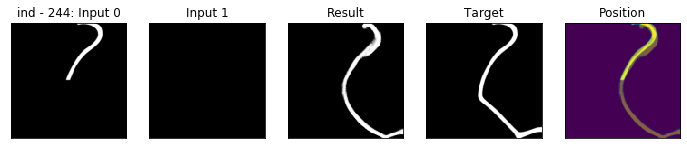

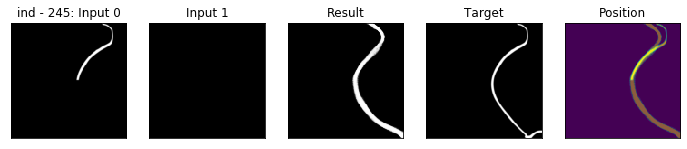

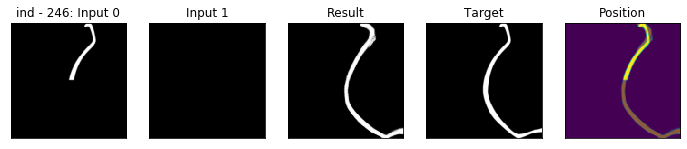

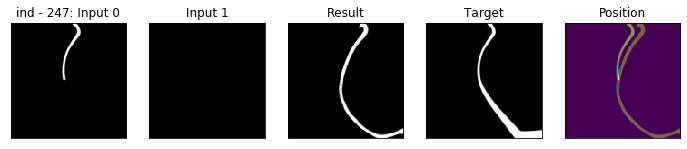

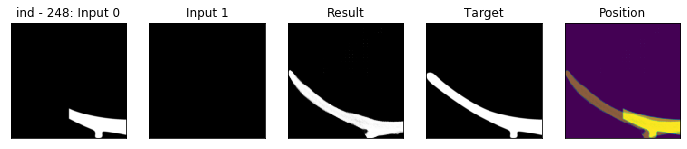

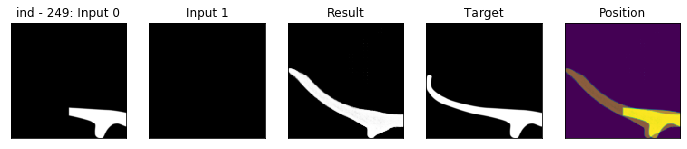

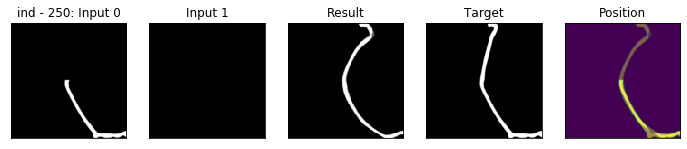

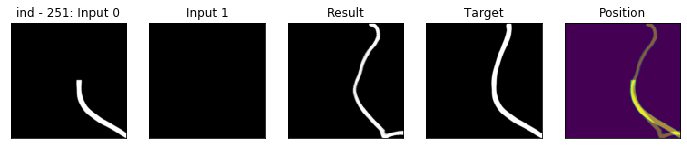

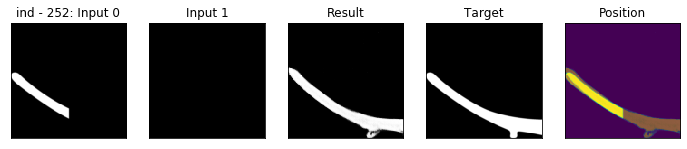

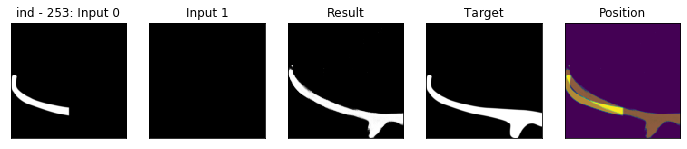

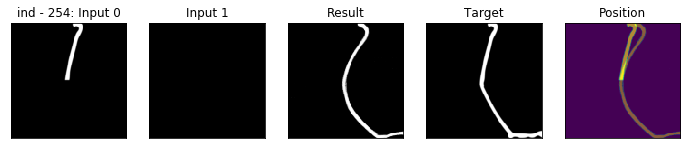

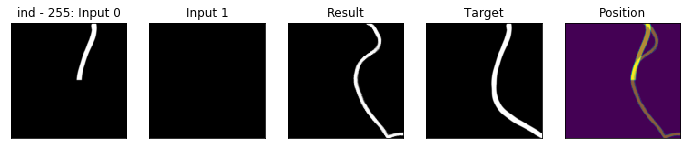

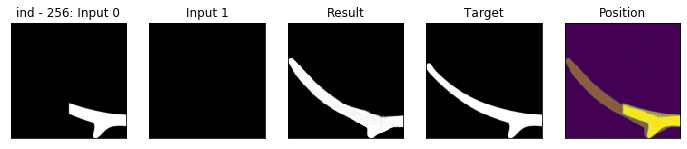

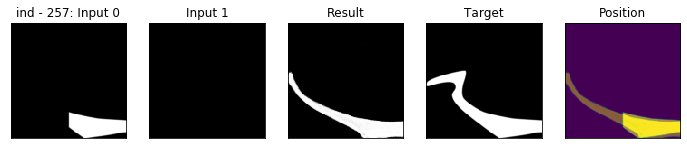

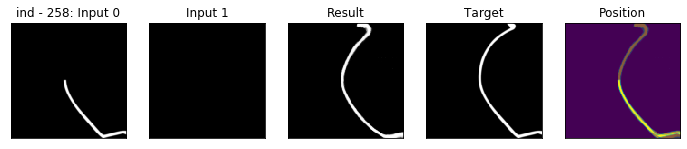

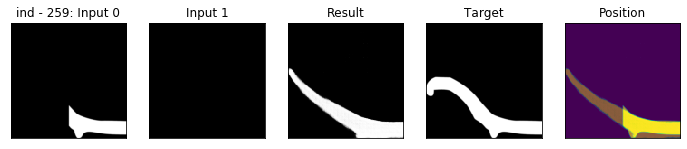

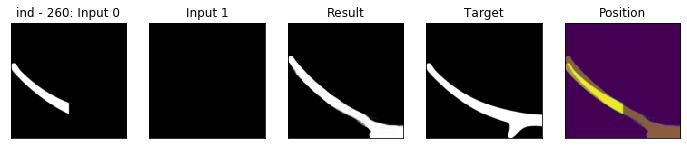

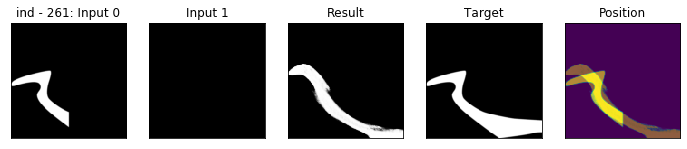

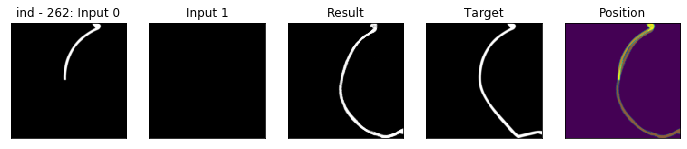

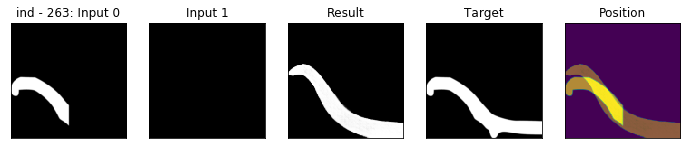

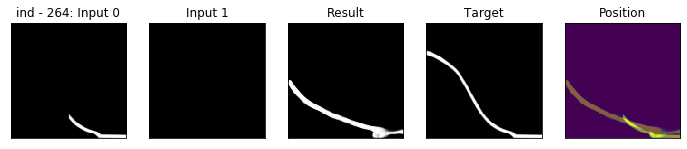

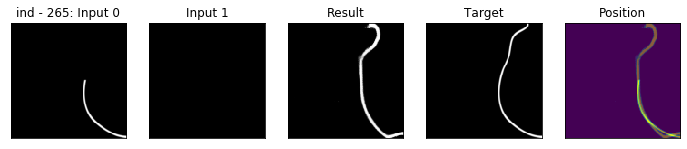

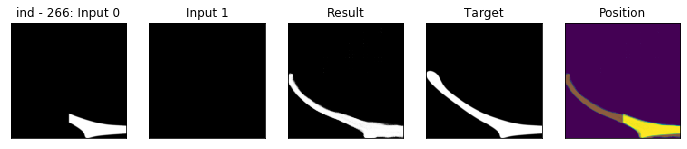

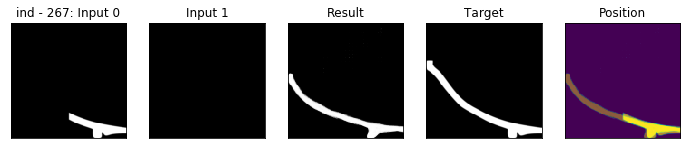

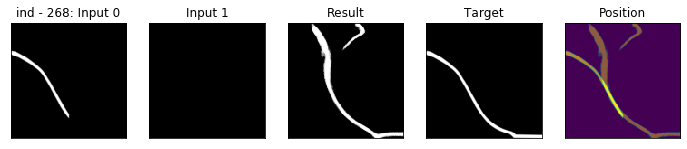

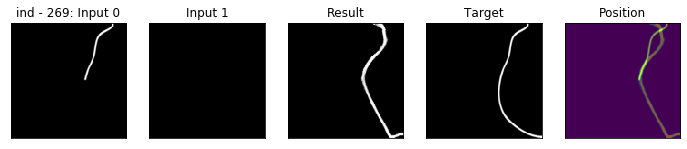

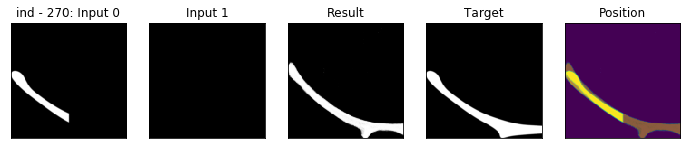

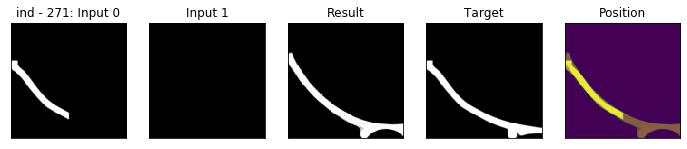

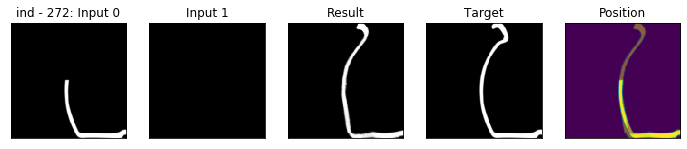

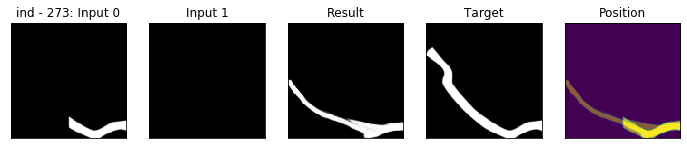

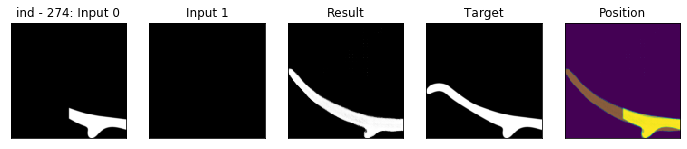

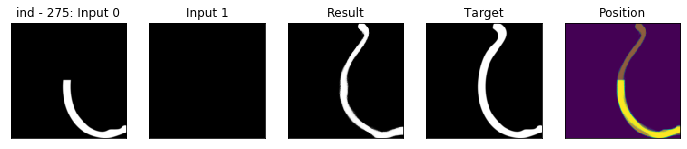

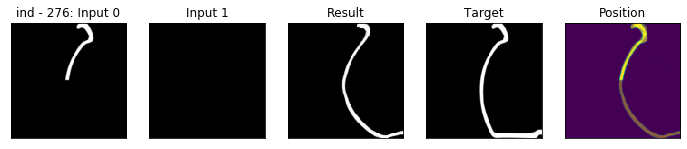

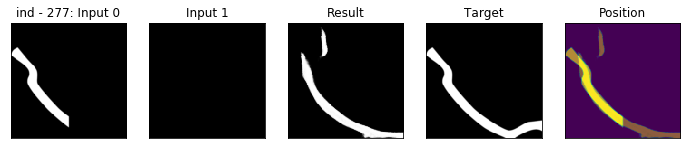

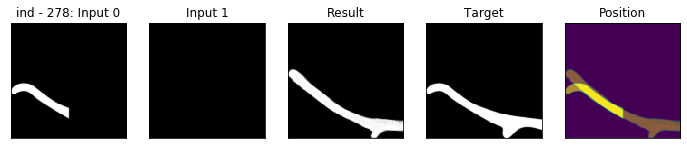

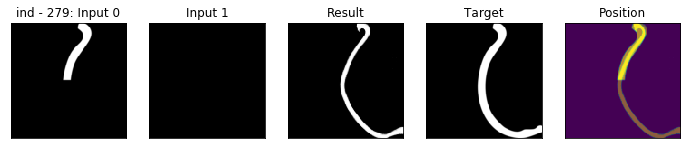

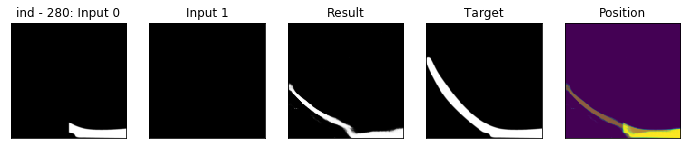

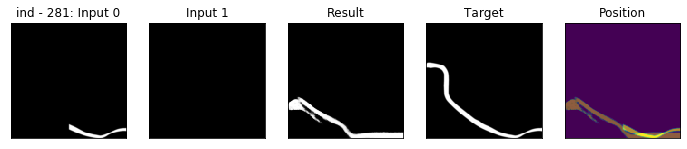

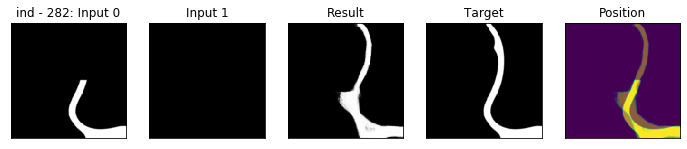

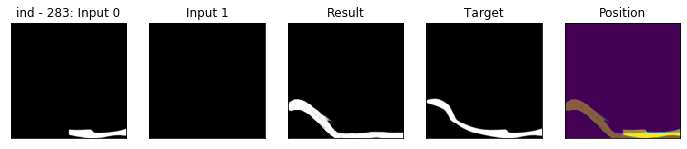

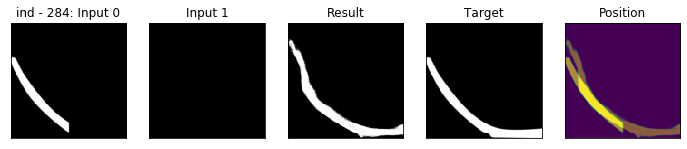

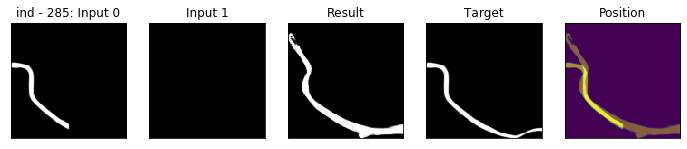

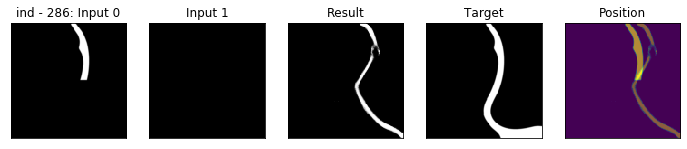

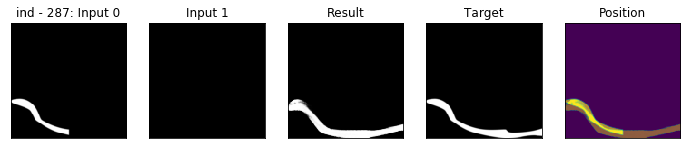

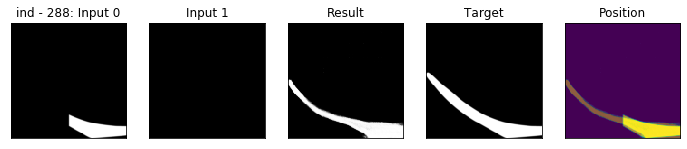

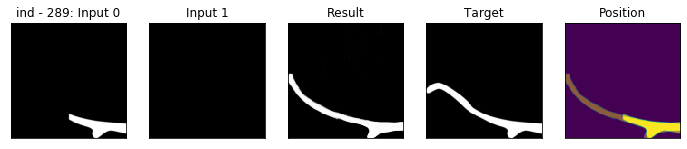

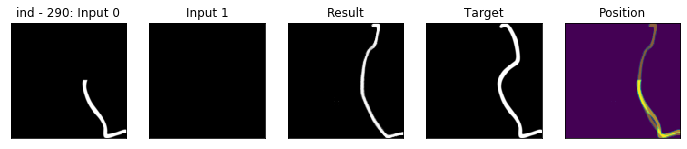

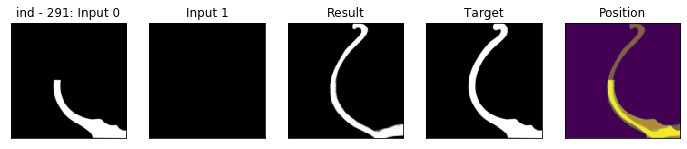

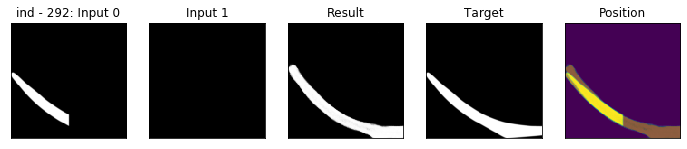

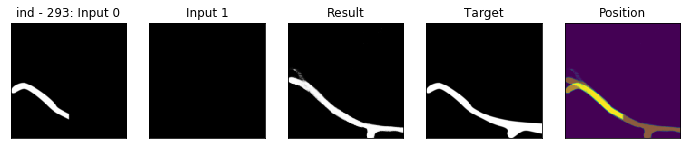

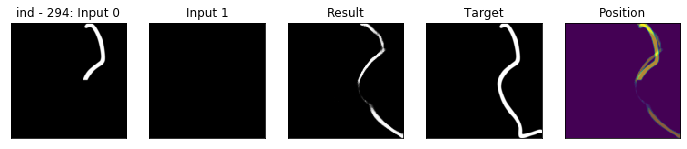

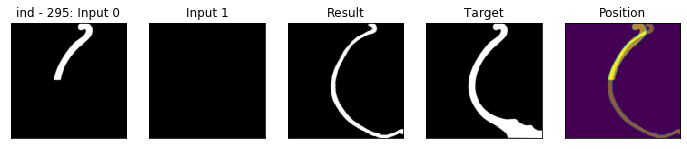

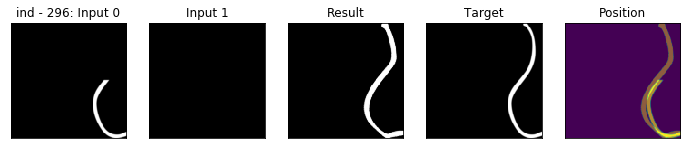

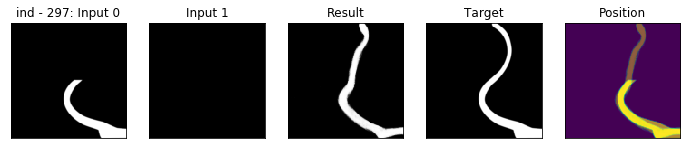

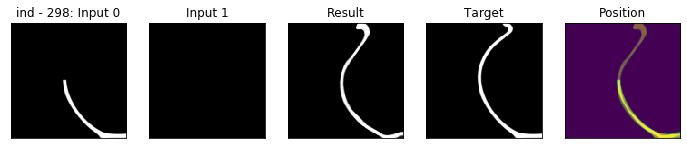

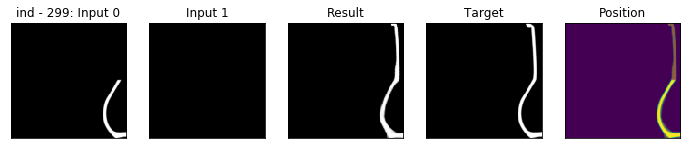

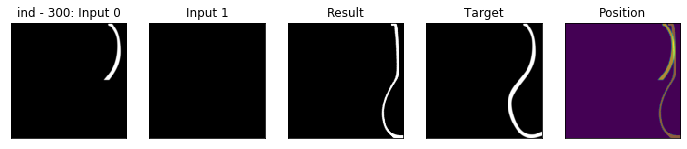

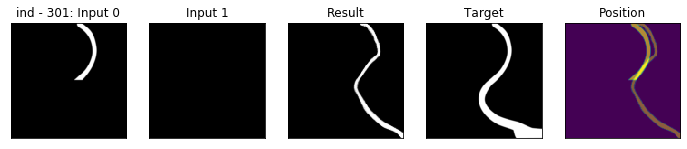

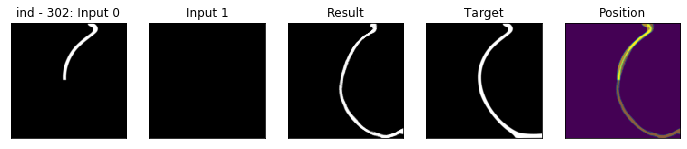

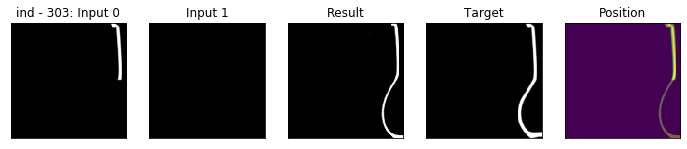

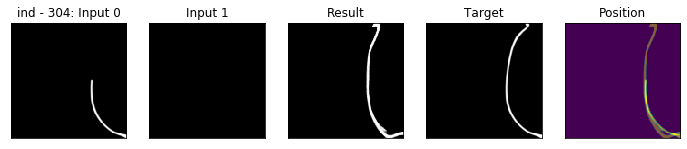

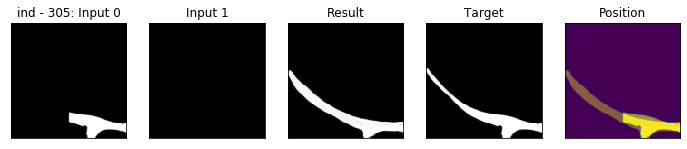

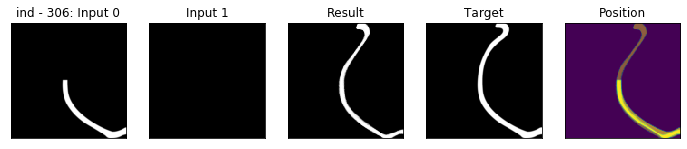

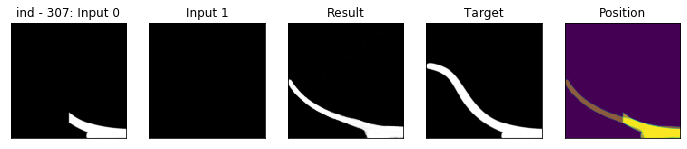

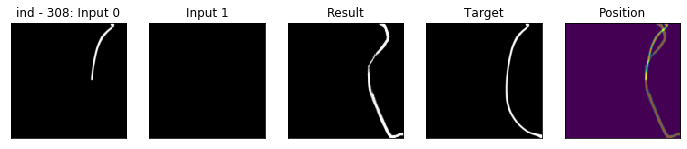

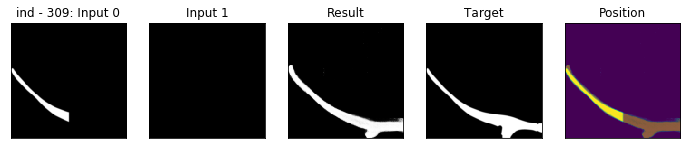

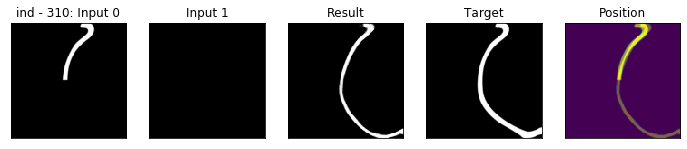

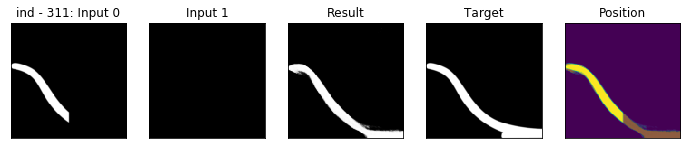

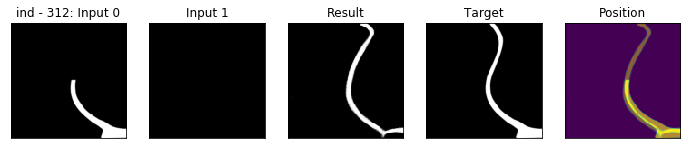

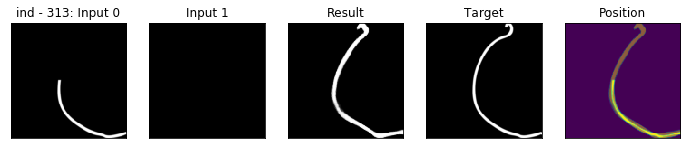

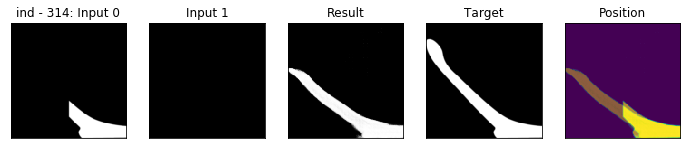

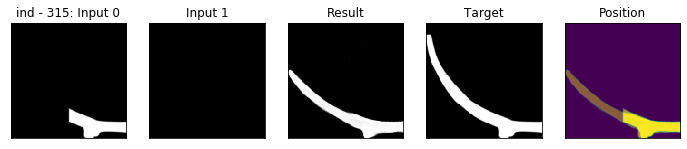

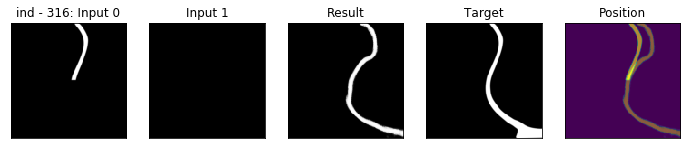

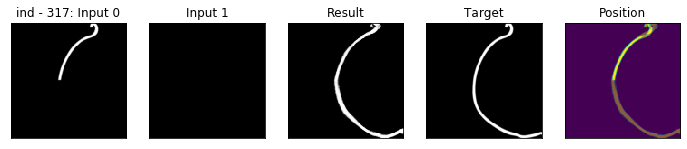

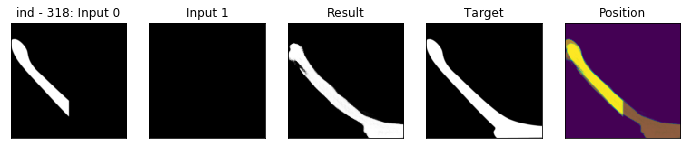

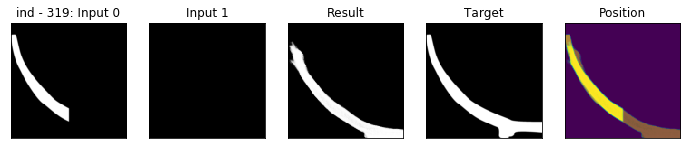

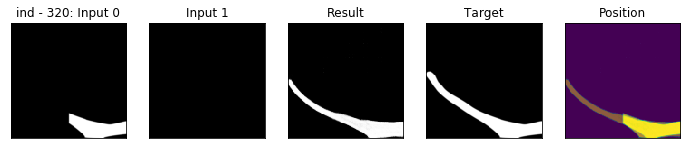

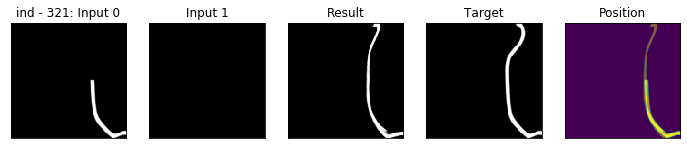

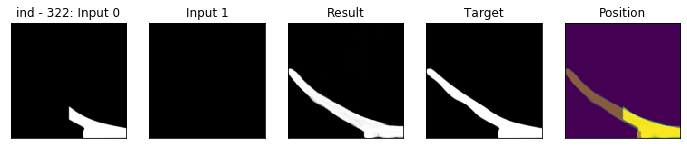

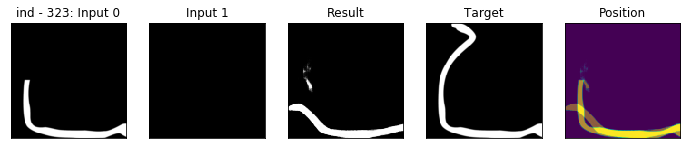

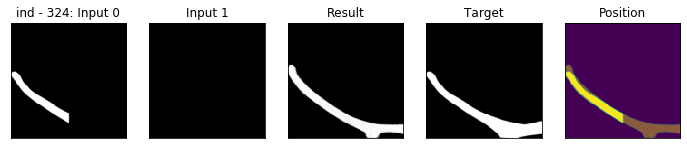

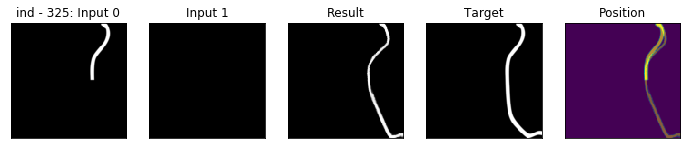

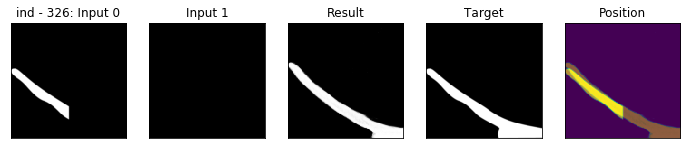

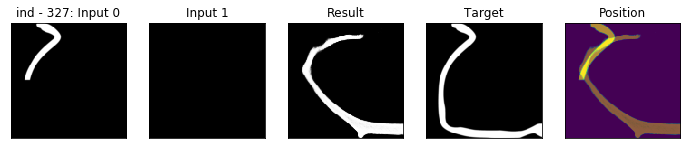

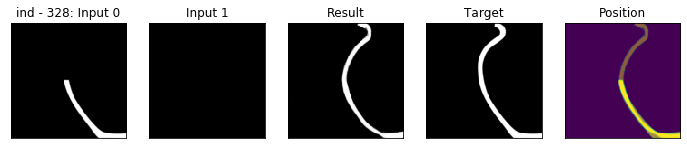

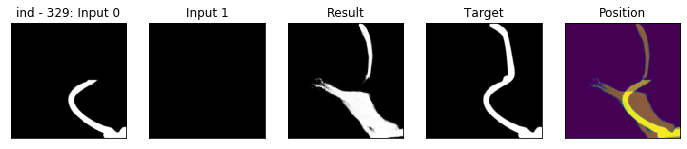

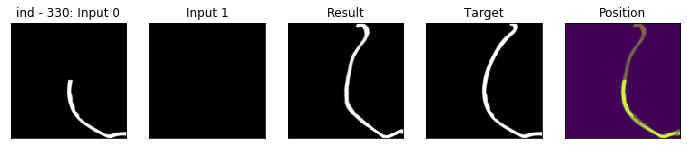

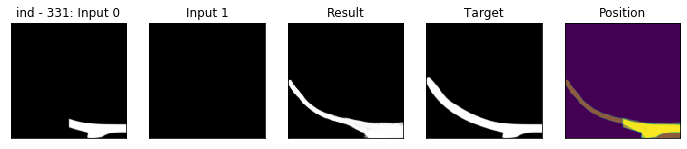

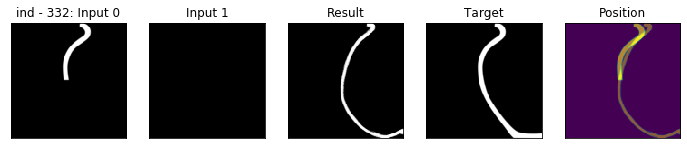

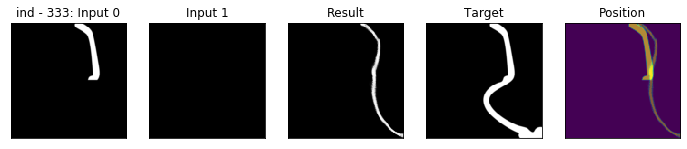

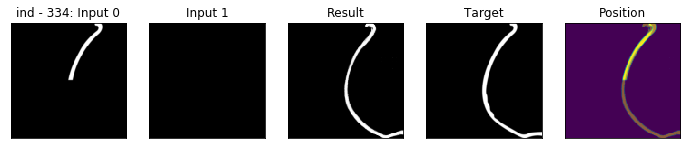

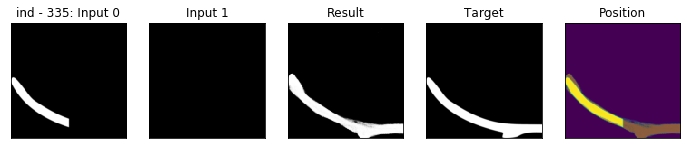

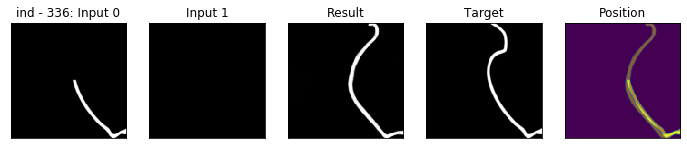

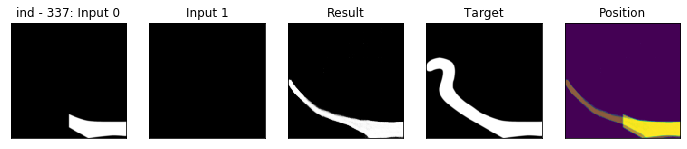

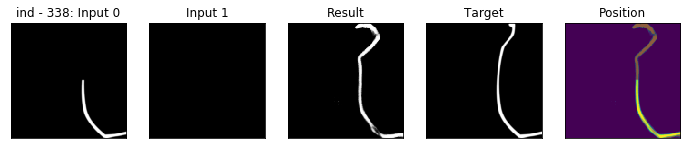

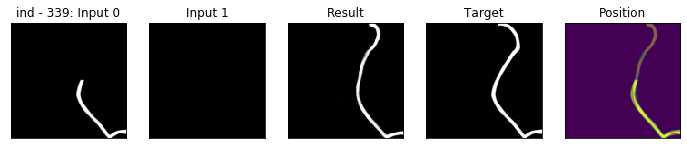

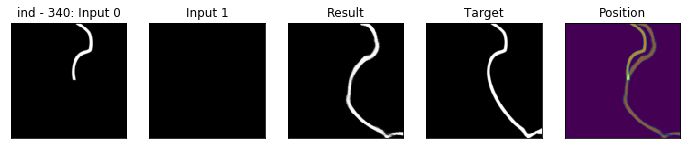

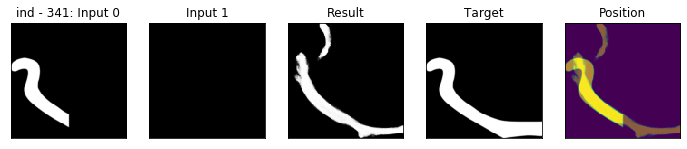

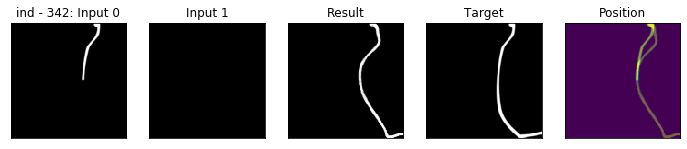

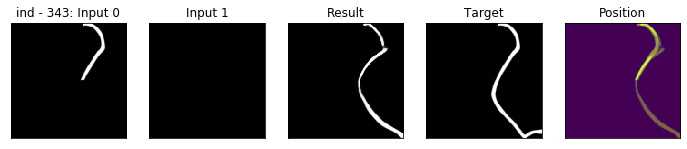

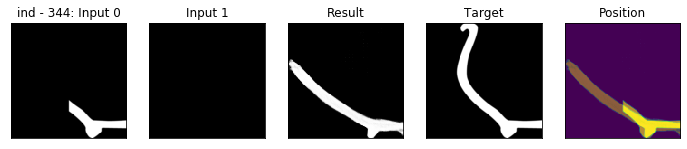

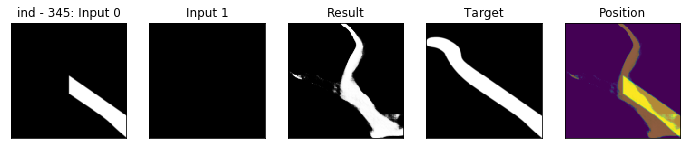

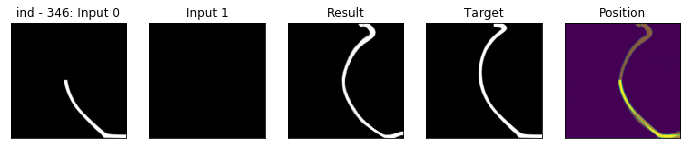

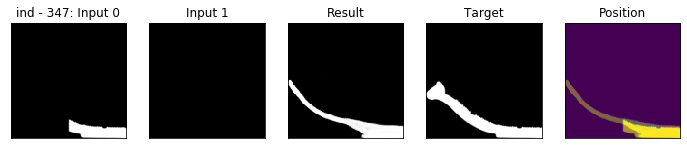

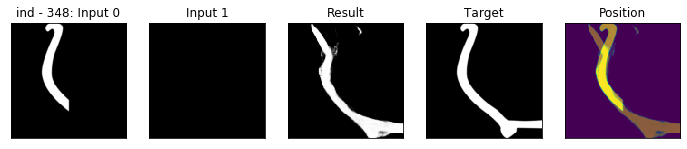

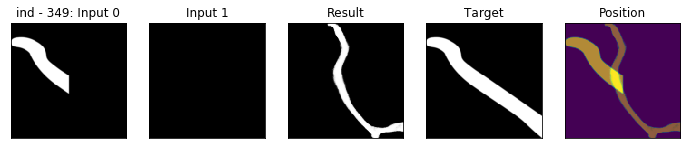

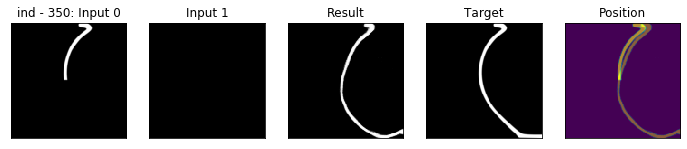

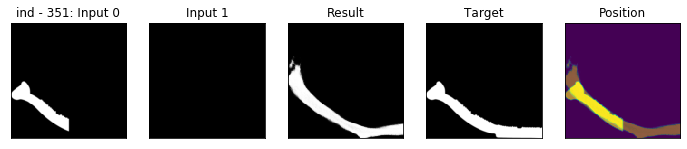

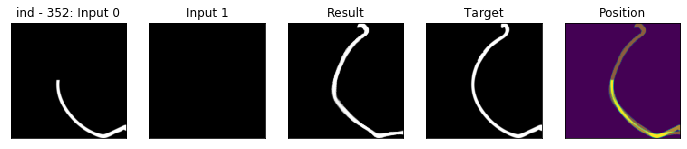

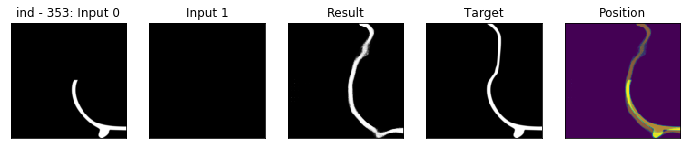

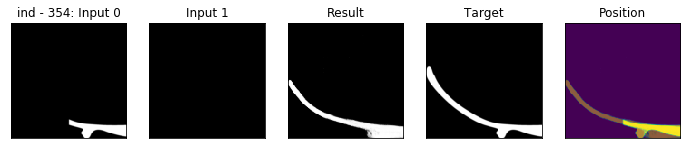

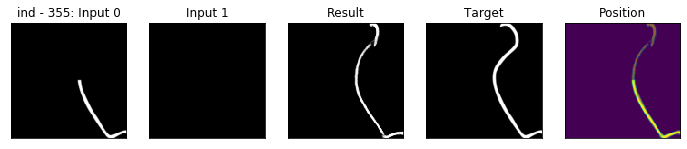

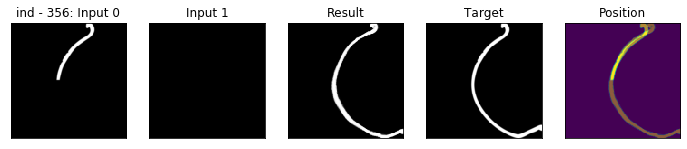

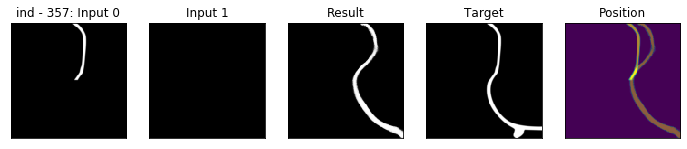

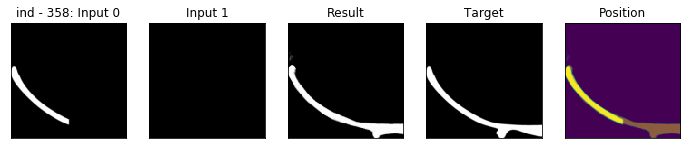

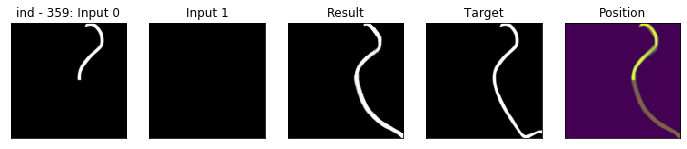

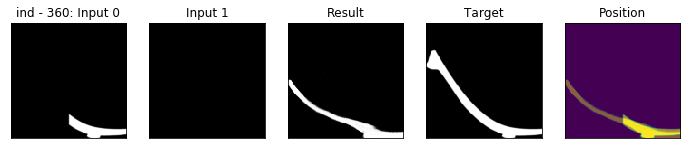

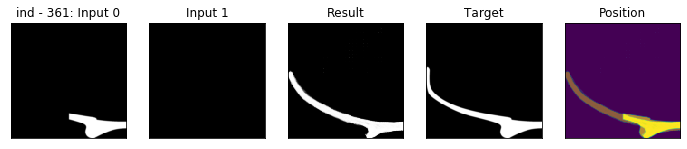

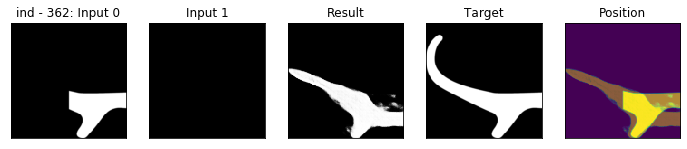

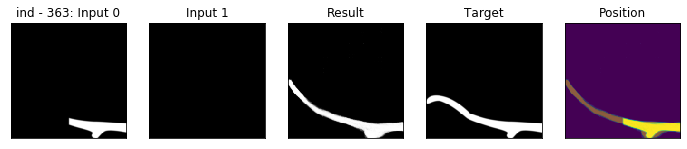

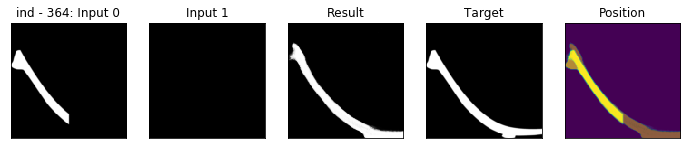

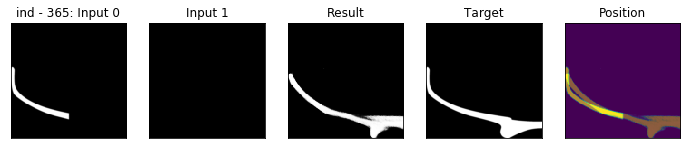

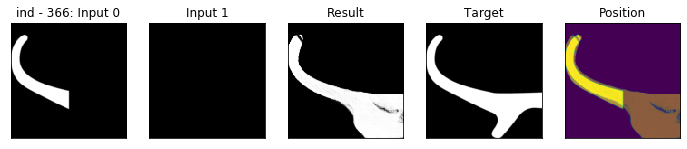

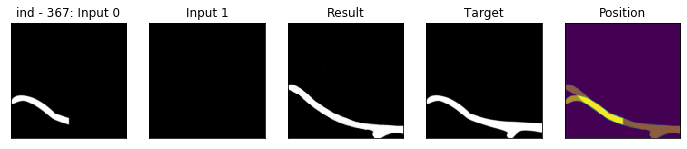

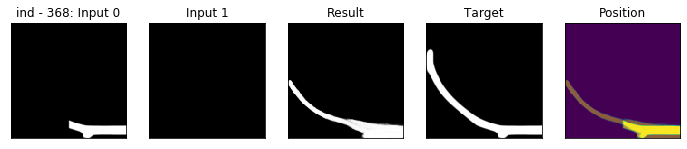

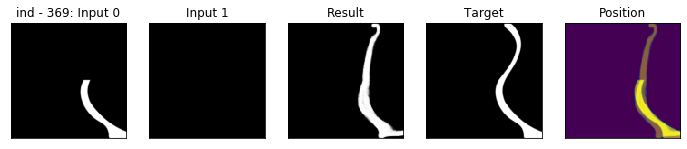

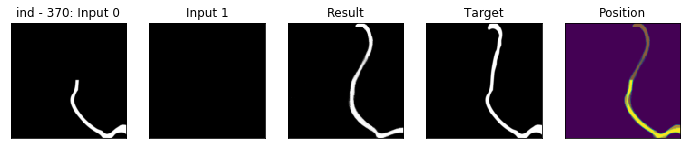

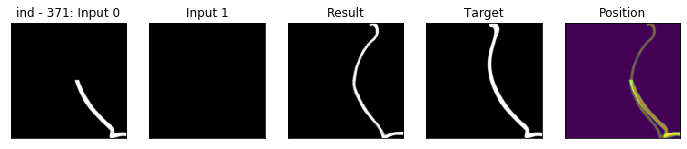

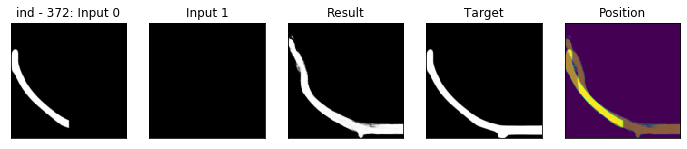

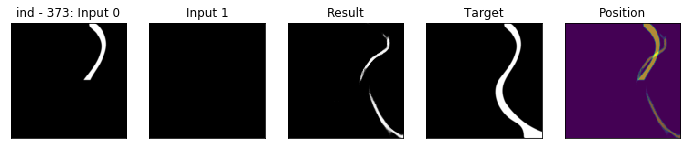

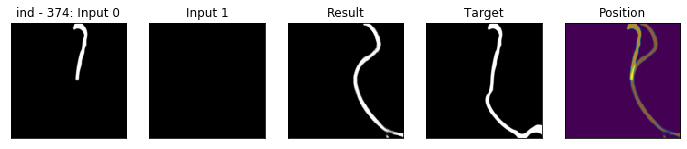

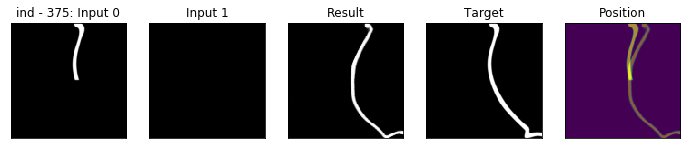

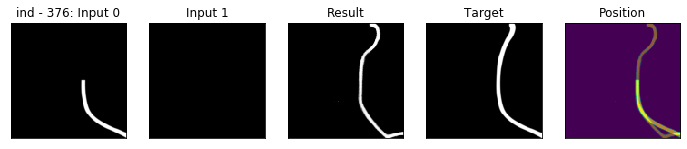

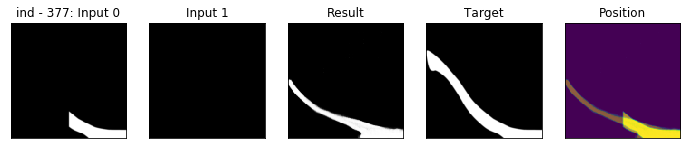

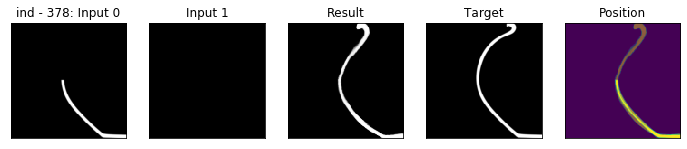

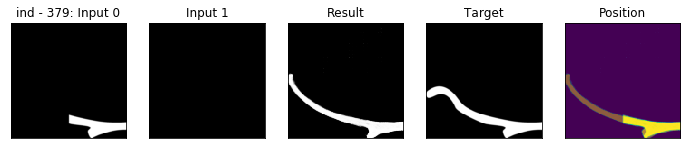

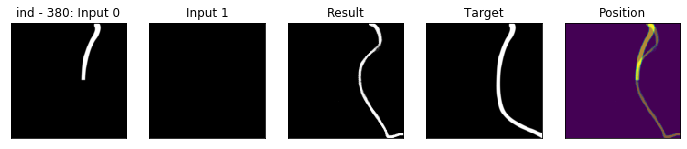

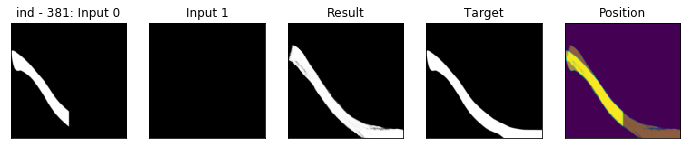

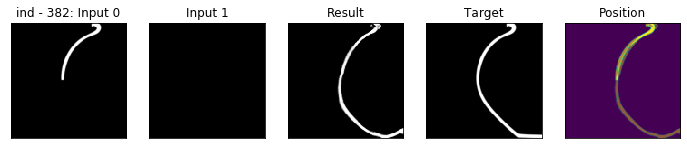

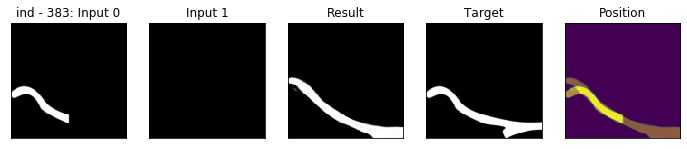

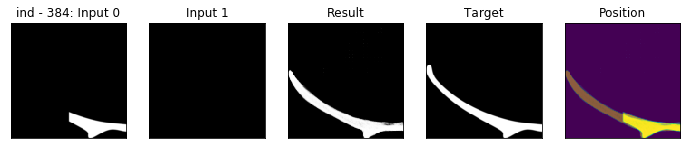

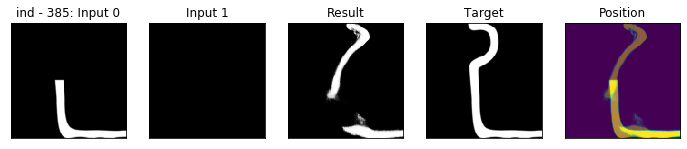

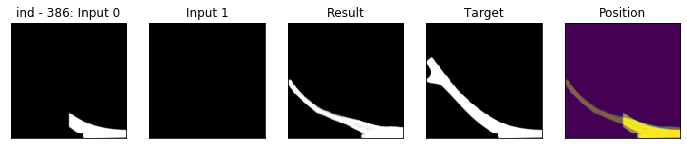

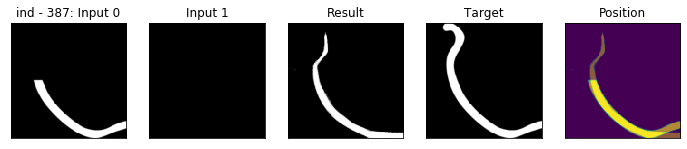

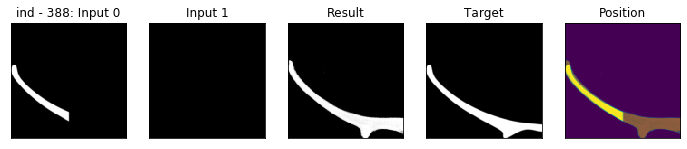

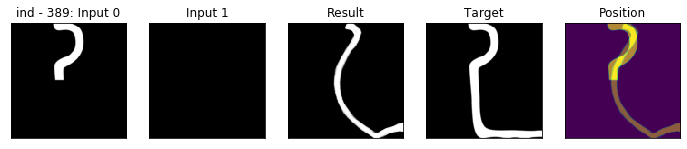

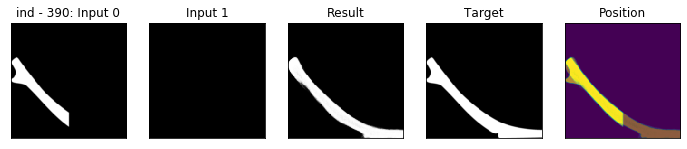

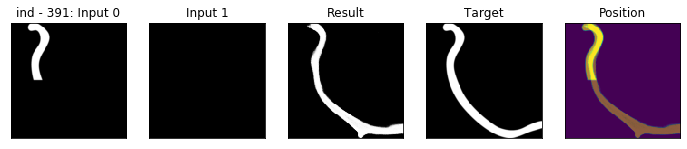

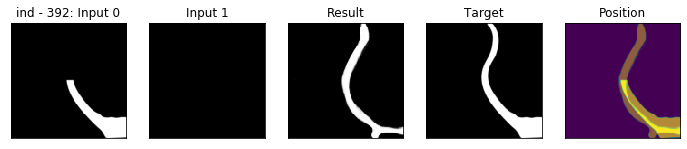

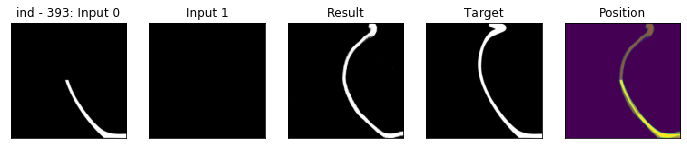

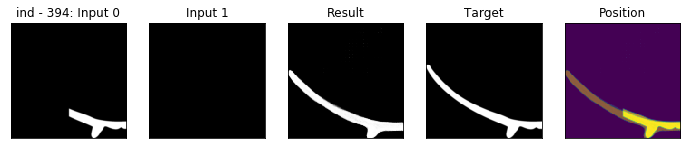

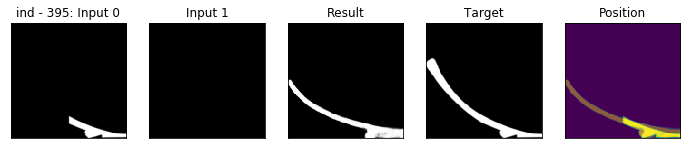

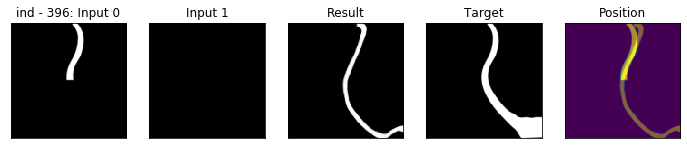

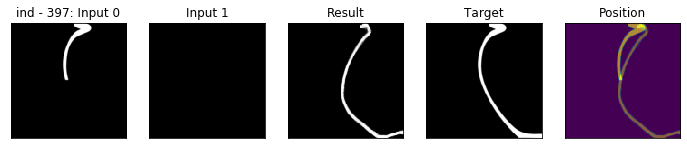

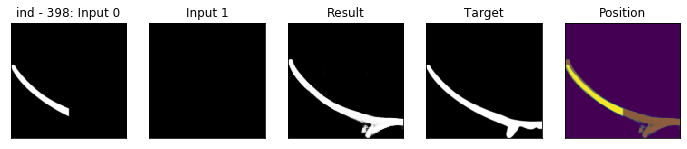

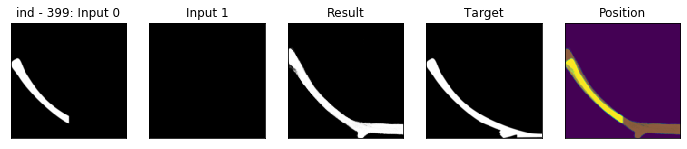

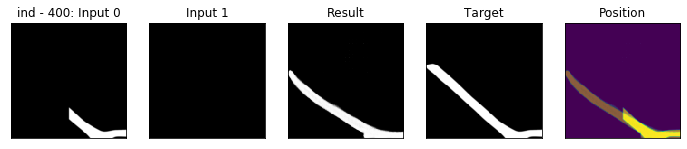

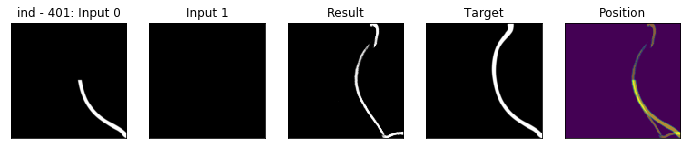

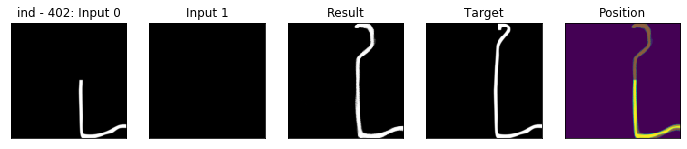

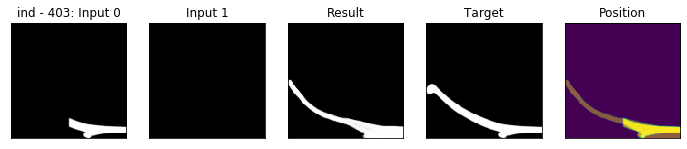

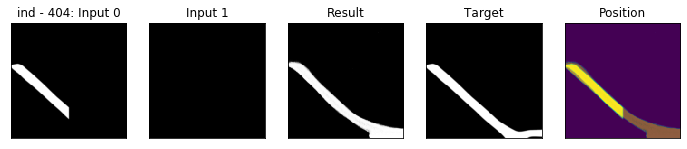

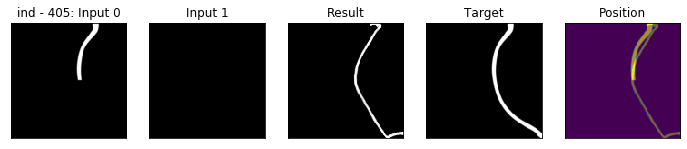

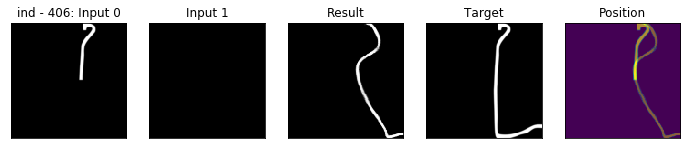

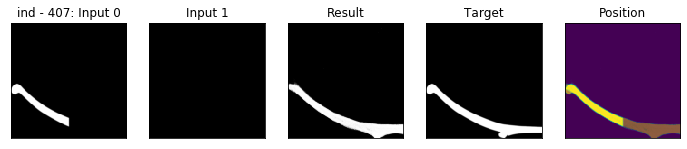

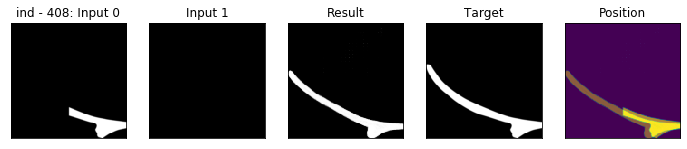

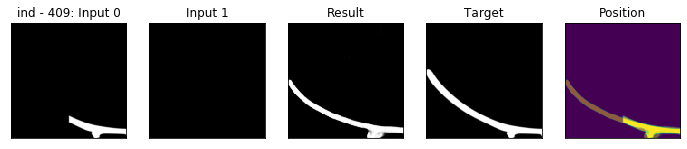

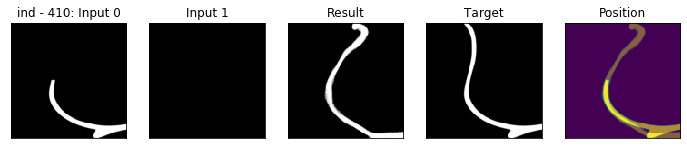

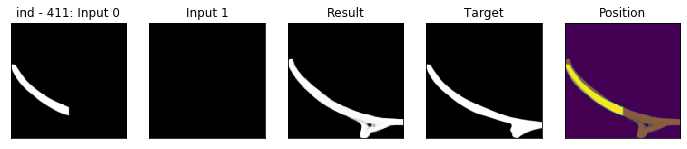

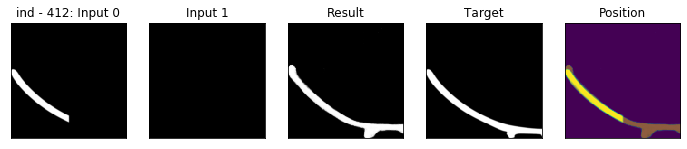

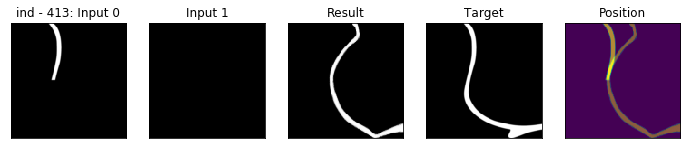

In [14]:
labels_pred = []
labels_target = []
labels_originals = []
real_data = []
fake_data = []
names_target = []
names_pred = []
random.seed(1)
v = 0


for batch, (image, labels, ids_name, tope, base, o_tope, o_base) in enumerate(test_loader, 0):

    tope, base, image = tope.to(available_device), base.to(available_device), image.to(available_device)
    o_tope, o_base = o_tope.to(available_device), o_base.to(available_device)
    #image[image>0.5] = 1.0
    #image[image<0.5] = 0
    
    blacks = torch.zeros_like(tope).to(available_device)
    target = torch.cat((tope, base, image), 1)
    
    predicted_A = model_G(tope, blacks)
    
    #predicted_A = model_G(tope, base)
    #predicted_A[predicted_A>0.5] = 1.0
    #predicted_A[predicted_A<0.5] = 0
    predicted_show = torch.cat((o_tope, blacks, predicted_A, image), 1)
    for i in range(predicted_show.shape[0]):
        imshow_msk(predicted_show[i].detach().cpu().numpy(), v)
        v = v + 1
    
        
    #predicted_B = model_G(tope, base)
    predicted_B = model_G(base, blacks)
    
    #predicted_B[predicted_B>0.5] = 1.0
    #predicted_B[predicted_B<0.5] = 0
    predicted_show = torch.cat((o_base, blacks, predicted_B, image), 1)
    for i in range(predicted_show.shape[0]):
        imshow_msk(predicted_show[i].detach().cpu().numpy(), v)
        v = v + 1
    
    labels_pred +=(classifier(predicted_A).tolist())
    labels_pred +=(classifier(predicted_B).tolist())
    labels_originals +=(classifier(image).tolist())
    labels_originals +=(classifier(image).tolist())
    
    predicted_A = predicted_A.detach().cpu().numpy().reshape(-1, 128, 128)
    predicted_B = predicted_B.detach().cpu().numpy().reshape(-1, 128, 128)
    fake_data += predicted_A.tolist()#.reshape(-1, 128, 128)#.detach().cpu().tolist()
    fake_data += predicted_B.tolist()#.reshape(-1, 128, 128)#.detach().cpu().tolist()
    
    image = image.detach().cpu().numpy().reshape(-1, 128, 128)
    real_data += image.tolist()
    real_data += image.tolist()
    
    labels_target += (labels.tolist())
    labels_target += (labels.tolist())
    
    names_target += np.asarray(ids_name).tolist()
    names_target += np.asarray(ids_name).tolist()
    
    names_pred +=['base'] * predicted_B.shape[0]
    names_pred +=['tope'] * predicted_B.shape[0]
    

In [15]:
names_pred = np.array(names_pred)
np.save('names_pred_v6c.npy', names_pred)

In [16]:
names_target = np.array(names_target)
np.save('names_target_v6c.npy', names_target)

In [17]:
import sh

In [18]:
sh.mkdir('-p', 'imagesFake_v6c')
sh.rm('-r','imagesFake_v6c')

sh.mkdir('-p', 'imageFakeTest_v6c')
#sh.rm('-r','imageFakeTest_v6c')


for i, (image, clases) in enumerate(zip(fake_data, labels_pred)):
    #plt.imshow(image, cmap=plt.cm.gray_r)
    sh.mkdir('-p','imagesFake_v6c/'+str(clases))
    plt.imsave('imagesFake_v6c/'+str(clases)+'/image_'+ str(i) + '.png', image, cmap=plt.cm.gray_r)
    plt.imsave('imageFakeTest_v6c/image_'+ str(i) + '.png', image, cmap=plt.cm.gray_r)
    plt.show()


In [20]:
sh.mkdir('-p', 'imagesReals_v6c')
sh.rm('-r','imagesReals_v6c')

sh.mkdir('-p', 'imageRealsTest_v6c')
#sh.rm('-r','imageRealsTest_v6c')

for i, (img, clases) in enumerate(zip(real_data, labels_target)):
    #plt.imshow(img, cmap=plt.cm.gray_r)
    sh.mkdir('-p','imagesReals_v6c/'+str(clases))
    plt.imsave('imagesReals_v6c/'+str(clases)+'/image_'+ str(i) + '.png', img, cmap=plt.cm.gray_r)
    plt.imsave('imageRealsTest_v6c/image_'+ str(i) + '.png', img, cmap=plt.cm.gray_r)
    plt.show()



In [21]:
from sklearn import metrics
print(metrics.classification_report(labels_originals, labels_pred))

              precision    recall  f1-score   support

           1       0.68      0.65      0.66       226
           9       0.60      0.63      0.61       188

    accuracy                           0.64       414
   macro avg       0.64      0.64      0.64       414
weighted avg       0.64      0.64      0.64       414



In [22]:
real_data = np.array(real_data)

In [23]:
fake_data = np.array(fake_data)

In [24]:
#real_data = classifier_partial(torch.Tensor(real_data).to(available_device)).detach().cpu().numpy()
#fake_data = classifier_partial(torch.Tensor(fake_data).to(available_device)).detach().cpu().numpy()

In [25]:
real_data = np.vstack([np.array(data).ravel() for data in real_data])
fake_data = np.vstack([np.array(data).ravel() for data in fake_data])
all_data = np.vstack([real_data, fake_data])

In [26]:
real_labels = np.ones((real_data.shape[0], 1))
fake_labels = np.zeros((fake_data.shape[0], 1))
all_labels = np.vstack([real_labels, fake_labels])

In [27]:
name_dic = {0.0:'Real',
1.0:'Fake'}

In [28]:
all_data.shape

(828, 16384)

In [29]:
from sklearn.decomposition import PCA # using randomized Singular Value Decomposition

pca = PCA(n_components=2).fit(all_data)
Xp = pca.transform(all_data)

In [30]:
np.sum(pca.explained_variance_ratio_)

0.2616800496774306

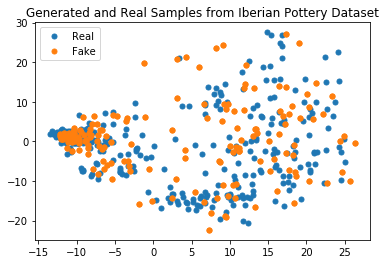

In [31]:
#labels_dict = {0.0:'Generated', 1.0:'Real'}
import pandas as pd

pca_df = pd.DataFrame(Xp, columns=['PC1', 'PC2'])
labels = pd.DataFrame(all_labels, columns=['class'])
#labels = labels.replace(labels_dict)
pca_df = pd.concat([pca_df, labels], axis=1)

groups = pca_df.groupby('class')

# Plot

fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
        ax.plot(group.PC1, group.PC2, marker='o', linestyle='', ms=5, label=name_dic[name], alpha=1)
        #print(group)
        #for i, row in group.iterrows():
            #print(row.id)
            #ax.annotate(row.id, (row.x, row.y), alpha=0.5)

#ax.set_xlim([-7000, 50000])
#ax.set_ylim([-3000, 6000])
plt.title('Generated and Real Samples from Iberian Pottery Dataset')
ax.legend()
plt.savefig('./pca_comparison_v6c.png', dpi=300)
plt.show()

In [32]:
import seaborn as sns

<Figure size 432x288 with 0 Axes>

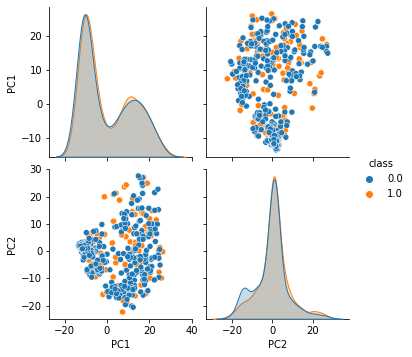

In [33]:
plt.tight_layout()
sns.pairplot(pca_df, hue='class')
plt.title('')
plt.savefig('pca_comparison_V3.png', bbox_inches='tight',  dpi=300)

In [34]:
import scipy.stats

density_real = scipy.stats.gaussian_kde(Xp[:real_data.shape[0]].ravel())
density_fake = scipy.stats.gaussian_kde(Xp[real_data.shape[0]:].ravel())

In [35]:
stats.ks_2samp(density_real.resample(400).ravel(), density_fake.resample(400).ravel())

Ks_2sampResult(statistic=0.1225, pvalue=0.004907932356726081)

In [36]:
stats.ks_2samp(density_real.resample(400).ravel(), density_real.resample(400).ravel())

Ks_2sampResult(statistic=0.06, pvalue=0.4680435421303692)

In [37]:
x_1 = fake_data
y_1 = real_data

In [38]:
import sys
sys.path.append('../geometry-score/')
import gs

In [39]:
y_1[y_1 > 0.5] = 1
y_1[y_1 <= 0.5] = 0

In [40]:
x_1[x_1 > 0.5] = 1
x_1[x_1 <= 0.5] = 0

In [41]:
# Finally, compute RLT

In [42]:
rlts_fake = gs.rlts(x_1, gamma=1.0/128, n=x_1.shape[0])
mrlt_fake = np.mean(rlts_fake, axis=0)

Done 0/414
Done 10/414
Done 20/414
Done 30/414
Done 40/414
Done 50/414
Done 60/414
Done 70/414
Done 80/414
Done 90/414
Done 100/414
Done 110/414
Done 120/414
Done 130/414
Done 140/414
Done 150/414
Done 160/414
Done 170/414
Done 180/414
Done 190/414
Done 200/414
Done 210/414
Done 220/414
Done 230/414
Done 240/414
Done 250/414
Done 260/414
Done 270/414
Done 280/414
Done 290/414
Done 300/414
Done 310/414
Done 320/414
Done 330/414
Done 340/414
Done 350/414
Done 360/414
Done 370/414
Done 380/414
Done 390/414
Done 400/414
Done 410/414


In [43]:
rlts_real = gs.rlts(y_1, gamma=1.0/128, n=y_1.shape[0])
mrlt_real = np.mean(rlts_real, axis=0)

Done 0/414
Done 10/414
Done 20/414
Done 30/414
Done 40/414
Done 50/414
Done 60/414
Done 70/414
Done 80/414
Done 90/414
Done 100/414
Done 110/414
Done 120/414
Done 130/414
Done 140/414
Done 150/414
Done 160/414
Done 170/414
Done 180/414
Done 190/414
Done 200/414
Done 210/414
Done 220/414
Done 230/414
Done 240/414
Done 250/414
Done 260/414
Done 270/414
Done 280/414
Done 290/414
Done 300/414
Done 310/414
Done 320/414
Done 330/414
Done 340/414
Done 350/414
Done 360/414
Done 370/414
Done 380/414
Done 390/414
Done 400/414
Done 410/414


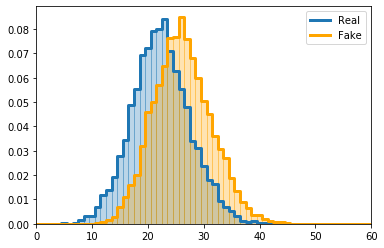

In [44]:
gs.fancy_plot(mrlt_real, label='Real')
gs.fancy_plot(mrlt_fake, label='Fake', color='orange')
plt.xlim([0, 60])
plt.legend()
plt.savefig('RLT_v3.png', bbox_inches='tight',  dpi=300)

In [45]:
print('GS-SCORE', gs.geom_score(rlts_fake, rlts_real))

GS-SCORE 0.014745028724496692


In [46]:
import cv2

criterion = nn.MSELoss()

def single_dice_coef(seg, gt):
    seg = seg.reshape(128, 128, -1)
    gt  = gt.reshape(128, 128, -1)
    #gt = gt[:,:, 0]
    #seg = seg[:,:, 0]
    
    #thresh = 128
    #seg = np.abs(cv2.threshold(seg, thresh, 1, cv2.THRESH_BINARY)[1] -1 )
    #gt = np.abs(cv2.threshold(gt, thresh, 1, cv2.THRESH_BINARY)[1] -1)
    #gt[gt == 255] = 1
    #seg[seg == 255] = 1
    dice = np.sum(seg[gt==1])*2.0 / (np.sum(seg) + np.sum(gt))
    return dice

In [47]:
def RMSE(seg, gt):
    #seg = seg.reshape(128, 128, -1)
    #gt  = gt.reshape(128, 128, -1)
    #gt = gt[:,:, 0]
    #seg = seg[:,:, 0]
    
    #thresh = 128
    #seg = np.abs(cv2.threshold(seg, thresh, 1, cv2.THRESH_BINARY)[1] -1 )
    #gt = np.abs(cv2.threshold(gt, thresh, 1, cv2.THRESH_BINARY)[1] -1)
    #gt[gt == 255] = 1
    #seg[seg == 255] = 1
    rmse = torch.sqrt(criterion(torch.Tensor(seg.reshape(1, 1, -1)), torch.Tensor(gt.reshape(1, 1, -1)))).tolist()
    return rmse

In [48]:
real_data.shape, fake_data.shape

((414, 16384), (414, 16384))

In [49]:
metricas = []
for f,r in zip(fake_data, real_data):
    metricas.append([RMSE(f, r), single_dice_coef(f, r)])

In [50]:
np.mean(metricas, 0)

array([0.23125148, 0.55119224])

In [1]:
!python -m pytorch_fid --dim 64 --device cuda imageFakeTest_v6c/ imageRealsTest_v6c/

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 15.10it/s]
FID:  0.01783061922772522


In [52]:
#!python -m pytorch_fid --dim 64 --device cuda imageRealsTest/ imageRealsTest/
#FID:  1.5248913243226525e-12
